Written by Margot Wagner, 2020

This notebook models calbindin binding in a variety of different ways and compares them to the binding captured experimentally in MCell. The methods included here are ODE (solver and Euler) and Markov. 

In [1]:
# import packages
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import glob
import math
from scipy.optimize import fsolve
from scipy import stats
import seaborn as sns

Calcium diffusion once it enters the axon presents a difficult problem as it succumbs to multiple different fates. In the axon, there are calbindin buffer volume molecules, plasma membrane calcium (PMCA) pump surface molecules, and calcium sensor SNARE surface molecules. All of which bind and unbind calcium once it has entered the axon. Of particular interest is the amount of calcium which reaches the calcium sensors on the SNARE complex as this dictates the neurotransmitter release from presynaptic vesicles. The markov chains for all three fates can be seen here as well as their approximate spatial location.

<img src="../figs/pre_machinery.png" width="400">

# MCell Mini Models

In order to capture the effects of the effects of the various molecules on calcium, we can set up MCell models which just focus on calcium in contact with a singular molecule type in the axon.

<img src="../figs/axon_geom.png" width="400">

## Calbindin binding

<img src="../figs/calbindin_kinetics.png" width="400">
<img src="../figs/calb_eqtns.png" width="200">

**Equations**

$$
\frac{d[H0M0]}{dt} = k_{M1M0}[H0M1] + k_{H1H0}[H1M0] - (k_{H0H1}[Ca^{2+}] + k_{M0M1}[Ca^{2+}])[H0M0]
$$  
\begin{split}
    \frac{d[H0M1]}{dt} = k_{M0M1}[Ca^{2+}][H0M0] + k_{M2M1}[H0M2] + k_{H1H0}[H1M1] \\
        - (k_{M1M0} + k_{H0H1}[Ca^{2+}] + k_{M1M2}[Ca^{2+}])[H0M1]
\end{split}  

$$
\frac{d[H0M2]}{dt} = k_{H1H0}[H1M2] + k_{M1M2}[Ca^{2+}][H0M1] - (k_{H0H1}[Ca^{2+}] + k_{M2M1})[H0M2] \]
$$  
\begin{split}
    \frac{d[H1M0]}{dt} =  k_{M1M0}[H1M1] + k_{H2H1}[H2M0] + k_{H0H1}[Ca^{2+}][H0M0] \\ 
        - (k_{H1H0} + k_{M0M1}[Ca^{2+}] + k_{H1H2}[Ca^{2+}])[H1M0] 
\end{split}  

\begin{split}
    \frac{d[H1M1]}{dt} = k_{H2H1}[H2M1] + k_{M2M1}[H1M2] + k_{M0M1}[Ca^{2+}][H1M0] + k_{H0H1}[Ca^{2+}][H0M1] \\
        -(k_{M1M0} + k_{H1H0} + k_{M1M2}[Ca^{2+}] + k_{H1H2}[Ca^{2+}])[H1M1]  
\end{split}  

\begin{split}
    \frac{d[H1M2]}{dt} =  k_{H2H1}[H2M2] + k_{M1M2}[Ca^{2+}][H1M1] + k_{H0H1}[Ca^{2+}][H0M2] \\
        -(k_{M2M1} + k_{H1H0} + k_{H1H2}[Ca^{2+}])[H1M2]
\end{split}  

$$
\frac{d[H2M0]}{dt} = k_{M1M0}[h2m1] + k_{H1H2}[Ca^{2+}][h1m0] -(k_{H2H1} + k_{M0M1}[Ca^{2+}])[h2m0]
$$  

\begin{split}
    \frac{d[H2M1]}{dt} = k_{M2M1}[H2M2] + k_{M0M1}[Ca^{2+}][H2M0] + k_{H1H2}[Ca^{2+}][H1M1] \\
        -(k_{H2H1} + k_{M1M0} + k_{M1M2}[Ca^{2+}])[H2M1] 
\end{split}  

$$
\frac{d[H2M2]}{dt} = k_{M1M2}[Ca^{2+}][H2M1] + k_{H1H2}[Ca^{2+}][H1M2]-(k_{H2H1} + k_{M2M1})[H2M2]
$$

### Find Number

In [2]:
'''Calbindin concentrations as constant number'''
AXON_RAD = 0.25    # micron
AXON_LEN = 4       # micron
CONC_CALB = 45e-6  # M
CONC_CA_BASE = 1e-7 # M
MICRON_TO_L = 1e-15   # unit conversion
AVAGADRO = 6.022e23   # avagadro's number
N_CA_AP = 5275     # avg ca after ap

# find axon volume
axon_vol_um3 = math.pi*(AXON_RAD**2)*AXON_LEN    # micron^3
axon_vol = axon_vol_um3*MICRON_TO_L    # liters

# convert concentrations to constant numbers
n_calb = int(round(axon_vol * CONC_CALB * AVAGADRO))
n_ca_base = int(round(axon_vol * CONC_CA_BASE * AVAGADRO))

# convert number of calcium after ap to concentration
conc_ca_ap = N_CA_AP/(axon_vol * AVAGADRO)
conc_ca = CONC_CA_BASE + conc_ca_ap # M

In [3]:
'''Calbindin concentrations as constant number'''
AXON_RECT_L = 4    # micron
AXON_RECT_W = 0.5
AXON_RECT_H = 0.5
CONC_CALB = 45e-6  # M
MICRON_TO_L = 1e-15   # unit conversion
AVAGADRO = 6.022e23   # avagadro's number

# find axon volume
axon_rect_vol_um3 = AXON_RECT_L*AXON_RECT_W*AXON_RECT_H    # micron^3
axon_rect_vol = axon_rect_vol_um3*MICRON_TO_L    # liters

# convert concentrations to constant numbers
n_calb_rect = int(round(axon_rect_vol * CONC_CALB * AVAGADRO))

n_calb_rect


27099

In [4]:
n_calb

21284

### ODEs

#### Find initial values

In [5]:
def calb_ss(calb):
    '''
     ODEs to describe calbindin kinetics according to Bartol et al (2015)
     input:        calb:        array of calbindin concentrations (arr, 9 x 1)
     output:       eqtns:          the blender user-set value of the parameter (float or None)
     '''
    
    # k_values meaning
    TWO_BIND_SITES = 2 # factor for two open binding sites
    K_MED_FOR = 8.7e7    # medium affinity forward binding
    K_MED_REV = 35.8     # medium affinity reverse binding
    K_HIGH_FOR = 1.1e7    # high affinity forward binding
    K_HIGH_REV = 2.6      # high affinity reverse binding

    # k_m0m1, k_m1m2, k_m1m0, k_m2m1, k_h0h1, k_h1h2, k_h1h2, k_h1h0, k_h2h1
    CALB_K_VALS = [TWO_BIND_SITES*K_MED_FOR, 
                   K_MED_FOR, 
                   K_MED_REV, 
                   TWO_BIND_SITES*K_MED_REV,
                   TWO_BIND_SITES*K_HIGH_FOR,
                   K_HIGH_FOR, 
                   K_HIGH_REV, 
                   TWO_BIND_SITES*K_HIGH_REV]
    
    # Unpack input
    h0m0, h0m1, h0m2, h1m0, h1m1, h1m2, h2m0, h2m1, h2m2 = calb
    k_m0m1, k_m1m2, k_m1m0, k_m2m1, k_h0h1, k_h1h2, k_h1h0, k_h2h1 = CALB_K_VALS
    
    # calcium
    ca = CONC_CA_BASE
    
    eqtns = []
    
    eqtns.append(-(k_h0h1*ca + k_m0m1*ca)*h0m0 + k_m1m0*h0m1 + k_h1h0*h1m0)
    
    eqtns.append(-(k_m1m0 + k_h0h1*ca + k_m1m2*ca)*h0m1 + k_m0m1*ca*h0m0 + k_m2m1*h0m2 + k_h1h0*h1m1)
    
    eqtns.append(-(k_h0h1*ca + k_m2m1)*h0m2 + k_h1h0*h1m2 + k_m1m2*ca*h0m1)
    
    eqtns.append(-(k_h1h0 + k_m0m1*ca + k_h1h2*ca)*h1m0 + k_m1m0*h1m1 + k_h2h1*h2m0 + k_h0h1*ca* h0m0) 
    
    eqtns.append(-(k_m1m0 + k_h1h0 + k_m1m2*ca + k_h1h2*ca)*h1m1 + k_h2h1*h2m1 + k_m2m1*h1m2 
                 + k_m0m1*ca* h1m0 + k_h0h1*ca*h0m1) 
    
    eqtns.append(-(k_m2m1 + k_h1h0 + k_h1h2*ca)*h1m2 + k_h2h1*h2m2 + k_m1m2*ca*h1m1 + k_h0h1*ca*h0m2)
    
    eqtns.append(-(k_h2h1 + k_m0m1*ca)*h2m0 + k_m1m0*h2m1 + k_h1h2*ca*h1m0)
    
    eqtns.append(-(k_h2h1 + k_m1m0 + k_m1m2*ca)*h2m1 + k_m2m1*h2m2 + k_m0m1*ca*h2m0 + k_h1h2*ca*h1m1)
    
    eqtns.append(-(k_h2h1 + k_m2m1)*h2m2 + k_m1m2*ca*h2m1 + k_h1h2*ca*h1m2)
    
    return eqtns

In [6]:
'''Solve for steady-state solutions of ODE'''   
N_STATES = 9
TWO_BIND_SITES = 2 # factor for two open binding sites
K_MED_FOR = 8.7e7    # medium affinity forward binding
K_MED_REV = 35.8     # medium affinity reverse binding
K_HIGH_FOR = 1.1e7    # high affinity forward binding
K_HIGH_REV = 2.6      # high affinity reverse binding

# k_m0m1, k_m1m2, k_m1m0, k_m2m1, k_h0h1, k_h1h2, k_h1h2, k_h1h0, k_h2h1
CALB_K_VALS = [TWO_BIND_SITES*K_MED_FOR, K_MED_FOR, K_MED_REV, 
               TWO_BIND_SITES*K_MED_REV, TWO_BIND_SITES*K_HIGH_FOR,
               K_HIGH_FOR, K_HIGH_REV, TWO_BIND_SITES*K_HIGH_REV]


conc_calb_x0 = np.ones(N_STATES)    # starting estimate for roots 

# Solve for roots of system of nonlinear equations
conc_calb = fsolve(calb_ss, conc_calb_x0)

# Fraction of calibnindin in each state at ss
# h0m0, h0m1, h0m2, h1m0, h1m1, h1m2, h2m0, h2m1, h2m2
calb_frac = np.empty(N_STATES)
for i in range(N_STATES):
    calb_frac[i] = conc_calb[i]/sum(conc_calb)

In [7]:
print(calb_frac)

[0.31958713 0.15533006 0.0188739  0.27041988 0.13143312 0.01597023
 0.0572042  0.02780316 0.00337832]


#### Solve ODE

In [6]:
def calb_odes(t, y):
    '''
     ODEs to describe calbindin kinetics according to Bartol et al (2015)
     input:        calb:        array of calbindin concentrations (arr, 9 x 1)
     output:       eqtns:       system of odes to describe calbindin
     '''
    
    # k_values meaning
    TWO_BIND_SITES = 2 # factor for two open binding sites
    K_MED_FOR = 8.7e7    # medium affinity forward binding (M ca/sec)
    K_MED_REV = 35.8     # medium affinity reverse binding
    K_HIGH_FOR = 1.1e7    # high affinity forward binding
    K_HIGH_REV = 2.6      # high affinity reverse binding

    # k_m0m1, k_m1m2, k_m1m0, k_m2m1, k_h0h1, k_h1h2, k_h1h2, k_h1h0, k_h2h1
    CALB_K_VALS = [TWO_BIND_SITES*K_MED_FOR, 
                   K_MED_FOR, 
                   K_MED_REV, 
                   TWO_BIND_SITES*K_MED_REV,
                   TWO_BIND_SITES*K_HIGH_FOR,
                   K_HIGH_FOR, 
                   K_HIGH_REV, 
                   TWO_BIND_SITES*K_HIGH_REV]
    
    # Unpack input
    h0m0, h0m1, h0m2, h1m0, h1m1, h1m2, h2m0, h2m1, h2m2, ca = y
    k_m0m1, k_m1m2, k_m1m0, k_m2m1, k_h0h1, k_h1h2, k_h1h0, k_h2h1 = CALB_K_VALS
    
    # calcium conc as baseline plus ap values
    #ca = conc_ca
    
    eqtns = []
    
    # d(h0m0)/dt 
    eqtns.append(-(k_h0h1*ca + k_m0m1*ca)*h0m0 + k_m1m0*h0m1 + k_h1h0*h1m0)
    
    # d(h0m1)/dt 
    eqtns.append(-(k_m1m0 + k_h0h1*ca + k_m1m2*ca)*h0m1 + k_m0m1*ca*h0m0 + k_m2m1*h0m2 + k_h1h0*h1m1)
    
    # d(h0m2)/dt
    eqtns.append(-(k_h0h1*ca + k_m2m1)*h0m2 + k_h1h0*h1m2 + k_m1m2*ca*h0m1)
    
    # d(h1m0)/dt 
    eqtns.append(-(k_h1h0 + k_m0m1*ca + k_h1h2*ca)*h1m0 + k_m1m0*h1m1 + k_h2h1*h2m0 + k_h0h1*ca*h0m0) 
    
    # d(h1m1)/dt
    eqtns.append(-(k_m1m0 + k_h1h0 + k_m1m2*ca + k_h1h2*ca)*h1m1 + k_h2h1*h2m1 + k_m2m1*h1m2 
                 + k_m0m1*ca* h1m0 + k_h0h1*ca*h0m1) 
    
    # d(h1m2)/dt
    eqtns.append(-(k_m2m1 + k_h1h0 + k_h1h2*ca)*h1m2 + k_h2h1*h2m2 + k_m1m2*ca*h1m1 + k_h0h1*ca*h0m2)
    
    # d(h2m0)/dt 
    eqtns.append(-(k_h2h1 + k_m0m1*ca)*h2m0 + k_m1m0*h2m1 + k_h1h2*ca*h1m0)
    
    # d(h2m1)/dt
    eqtns.append(-(k_h2h1 + k_m1m0 + k_m1m2*ca)*h2m1 + k_m2m1*h2m2 + k_m0m1*ca*h2m0 + k_h1h2*ca*h1m1)
    
    # d(h2m2)/dt
    eqtns.append(-(k_h2h1 + k_m2m1)*h2m2 + k_m1m2*ca*h2m1 + k_h1h2*ca*h1m2)
    
    # d(ca)/dt
    eqtns.append(- ( k_h0h1*(h0m0 + h0m1 + h0m2) + k_h1h2*(h1m0 + h1m1 + h1m2) + k_m0m1*(h0m0 + h1m0 + h2m0)
                   + k_m1m2*(h0m1 + h1m1 + h2m1) )*ca  +  k_h1h0*(h1m0 + h1m1 + h1m2) + k_h2h1*(h2m0 + h2m1 + h2m2)
                   + k_m1m0*(h0m1 + h1m1 + h2m1) + k_m2m1*(h0m2 + h1m2 + h2m2))
    
    return eqtns

In [7]:
from scipy.integrate import solve_ivp
'''solve_ivp(fun, t_span, y0)
    - fun:     RHS of the system, fun(t, y)
    - t_span:  integral of integration (t0, tf)
    - y0:      initial state
    
    returns bunch object with:
     - t     (n_points), time points
     - y     (n, n_points), values of the solution at t'''

T_START = 0
T_STOP = 0.005

# Initial concentrations
y0 = CONC_CALB*calb_frac    # IC in M
y0 = np.append(y0, conc_ca)

calb_sol = solve_ivp(calb_odes,[T_START, T_STOP], y0, method='LSODA' )

In [8]:
CA_IDX = 9

# Normalize
calb_sol.y[CA_IDX,:] = calb_sol.y[CA_IDX,:] / (conc_ca)
calb_sol.y[:CA_IDX,:] = calb_sol.y[:CA_IDX,:] / CONC_CALB

#### Plot

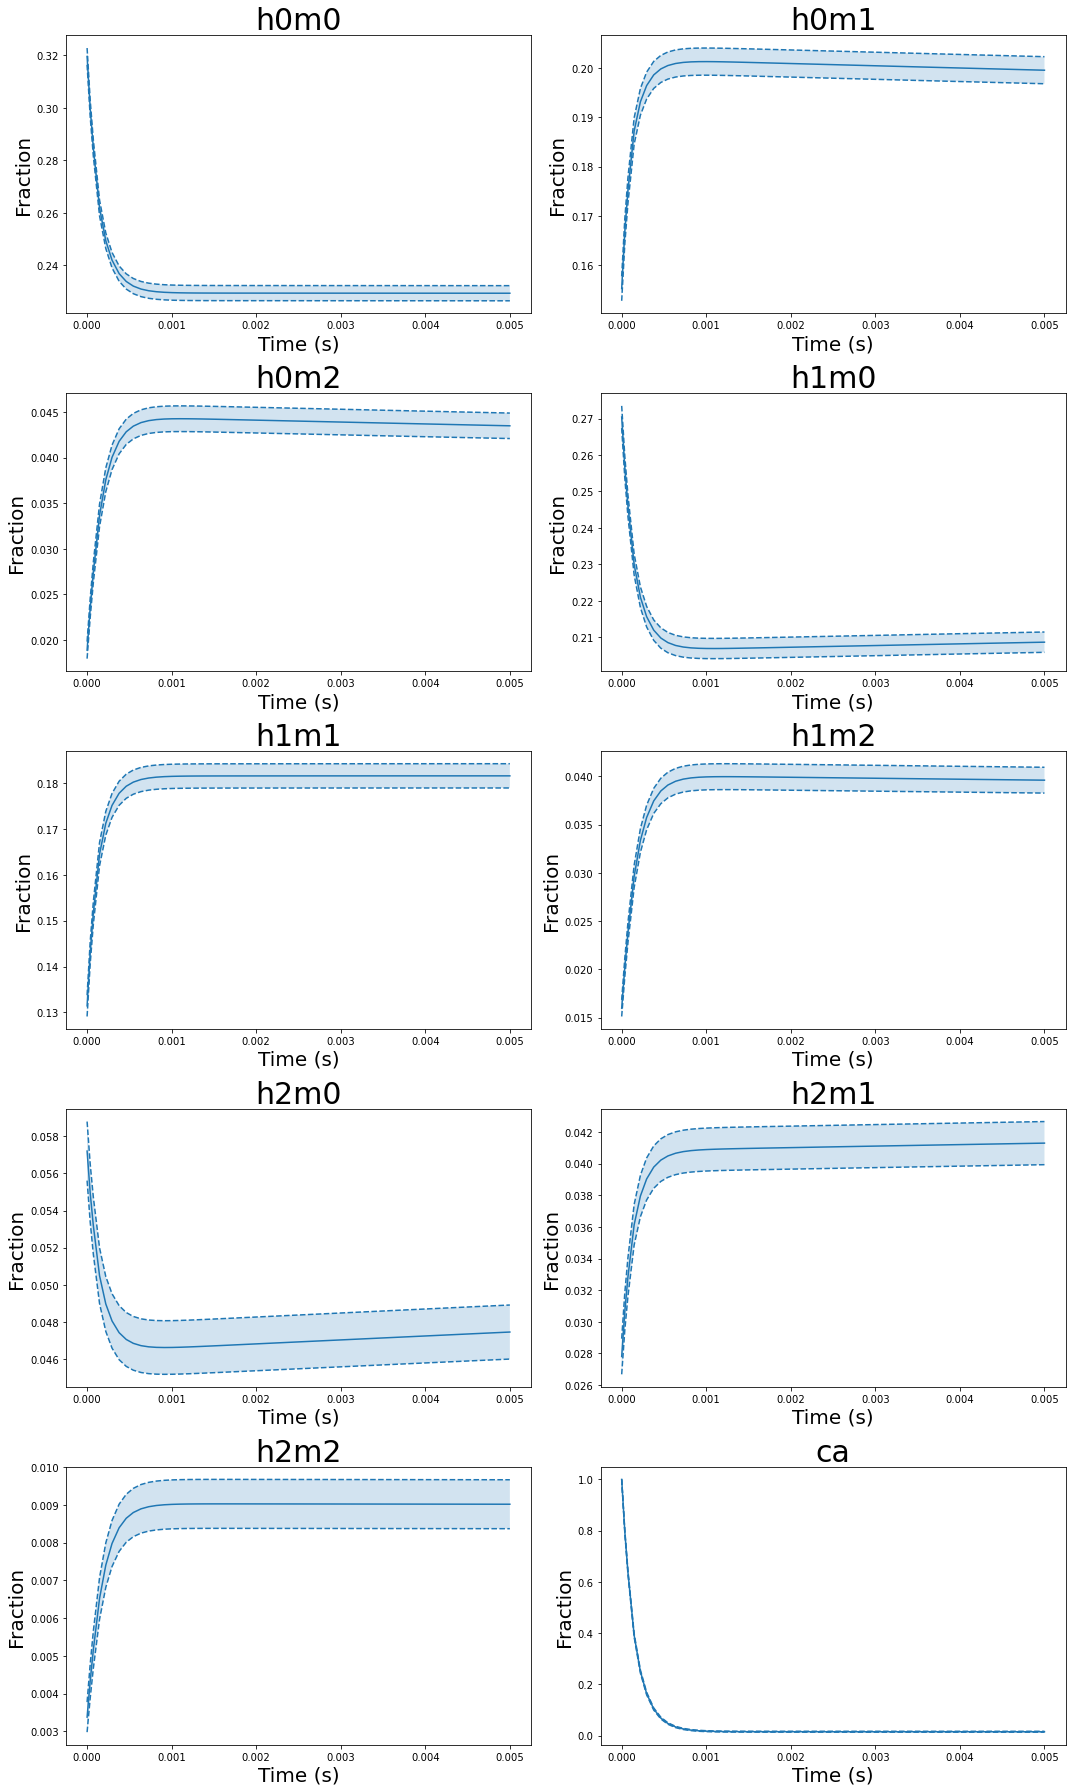

In [9]:
fig, ax = plt.subplots(5, 2, figsize = (15, 25))

mol_states = ['h0m0', 'h0m1', 'h0m2', 'h1m0', 'h1m1', 'h1m2', 'h2m0', 'h2m1', 'h2m2', 'ca']

for a, i in zip(ax.flatten(), range(len(y0))):
    # Std Dev norm factor
    if (i == CA_IDX):
        N = n_ca_base + N_CA_AP
    else:
        N = n_calb
        
    # Std dev  
    sd = np.sqrt(np.multiply(calb_sol.y[i,:], (1 - calb_sol.y[i,:]))/N)
    a.plot(calb_sol.t, np.add(calb_sol.y[i,:], sd), 'C0--')
    a.plot(calb_sol.t, np.subtract(calb_sol.y[i,:], sd), 'C0--')
    
    # Cloud 
    a.fill_between(calb_sol.t, np.add(calb_sol.y[i,:], sd), np.subtract(calb_sol.y[i,:], sd), alpha=0.2)
    
    # Mean 
    a.plot(calb_sol.t, calb_sol.y[i,:])
    a.set_title(mol_states[i], size=30)
    a.set_xlabel('Time (s)', size=20)
    a.set_ylabel('Fraction', size=20)
    
    # Standard error of mean
    #sem = stats.sem(calb_sol.y[i,:])
    #a.plot(calb_sol.t, np.add(calb_sol.y[i,:], sem), 'C1')
    #a.plot(calb_sol.t, np.subtract(calb_sol.y[i,:], sem), 'C1')
 
plt.tight_layout()
plt.show()


### Euler Integration

In [34]:
def calb_euler():
    # k values
    # k_values meaning
    TWO_BIND_SITES = 2 # factor for two open binding sites
    K_MED_FOR = 8.7e7    # medium affinity forward binding (M ca/sec)
    K_MED_REV = 35.8     # medium affinity reverse binding
    K_HIGH_FOR = 1.1e7    # high affinity forward binding
    K_HIGH_REV = 2.6      # high affinity reverse binding
    
    # k_m0m1, k_m1m2, k_m1m0, k_m2m1, k_h0h1, k_h1h2, k_h1h2, k_h1h0, k_h2h1
    CALB_K_VALS = [TWO_BIND_SITES*K_MED_FOR, 
                   K_MED_FOR, 
                   K_MED_REV, 
                   TWO_BIND_SITES*K_MED_REV,
                   TWO_BIND_SITES*K_HIGH_FOR,
                   K_HIGH_FOR, 
                   K_HIGH_REV, 
                   TWO_BIND_SITES*K_HIGH_REV]
    
    k_m0m1, k_m1m2, k_m1m0, k_m2m1, k_h0h1, k_h1h2, k_h1h0, k_h2h1 = CALB_K_VALS
    
    # Initial conditions
    y0 = CONC_CALB*calb_frac    # IC in M
    y0 = np.append(y0, conc_ca)
    
    # Time
    #dt = 0.000025
    #t_stop = 0.005
    dt = 1e-6
    t_stop = 0.01
    t_start = 0
    t = np.arange(t_start, t_stop+dt, dt)
    
    # Initialize states
    h0m0, h0m1, h0m2, h1m0, h1m1, h1m2, h2m0, h2m1, h2m2, ca = [np.zeros(len(t)) for _ in range(len(y0))]
    
    # Initial conditions
    h0m0[0] = y0[0]
    h0m1[0] = y0[1]
    h0m2[0] = y0[2]
    h1m0[0] = y0[3]
    h1m1[0] = y0[4]
    h1m2[0] = y0[5]
    h2m0[0] = y0[6]
    h2m1[0] = y0[7]
    h2m2[0] = y0[8]
    ca[0] = y0[9]
    
    
    h0m0[1] = h0m0[0] + (-(k_h0h1*ca[0] + k_m0m1*ca[0])*h0m0[0] + k_m1m0*h0m1[0] + k_h1h0*h1m0[0])*dt
    # Step forward in time
    for n in range(len(t) - 1):
        h0m0[n+1] = h0m0[n] + (-(k_h0h1*ca[n] + k_m0m1*ca[n])*h0m0[n] + k_m1m0*h0m1[n] + k_h1h0*h1m0[n])*dt
        
        h0m1[n+1] = h0m1[n] + (-(k_m1m0 + k_h0h1*ca[n] + k_m1m2*ca[n])*h0m1[n] + k_m0m1*ca[n]*h0m0[n] + k_m2m1*h0m2[n] + k_h1h0*h1m1[n])*dt
        
        h0m2[n+1] = h0m2[n] + (-(k_h0h1*ca[n] + k_m2m1)*h0m2[n] + k_h1h0*h1m2[n] + k_m1m2*ca[n]*h0m1[n])*dt
        
        h1m0[n+1] = h1m0[n] + (-(k_h1h0 + k_m0m1*ca[n] + k_h1h2*ca[n])*h1m0[n] + k_m1m0*h1m1[n] + k_h2h1*h2m0[n] + k_h0h1*ca[n]*h0m0[n])*dt 
        
        h1m1[n+1] = h1m1[n] + (-(k_m1m0 + k_h1h0 + k_m1m2*ca[n] + k_h1h2*ca[n])*h1m1[n] + k_h2h1*h2m1[n] + k_m2m1*h1m2[n] 
                     + k_m0m1*ca[n]*h1m0[n] + k_h0h1*ca[n]*h0m1[n])*dt 
        
        h1m2[n+1] = h1m2[n] + (-(k_m2m1 + k_h1h0 + k_h1h2*ca[n])*h1m2[n] + k_h2h1*h2m2[n] + k_m1m2*ca[n]*h1m1[n] + k_h0h1*ca[n]*h0m2[n])*dt
        
        h2m0[n+1] = h2m0[n] + (-(k_h2h1 + k_m0m1*ca[n])*h2m0[n] + k_m1m0*h2m1[n] + k_h1h2*ca[n]*h1m0[n])*dt
        
        h2m1[n+1] = h2m1[n] + (-(k_h2h1 + k_m1m0 + k_m1m2*ca[n])*h2m1[n] + k_m2m1*h2m2[n] + k_m0m1*ca[n]*h2m0[n] + k_h1h2*ca[n]*h1m1[n])*dt
        
        h2m2[n+1] = h2m2[n] + (-(k_h2h1 + k_m2m1)*h2m2[n] + k_m1m2*ca[n]*h2m1[n] + k_h1h2*ca[n]*h1m2[n])*dt
        
        ca[n+1] = ca[n] + (-( k_h0h1*(h0m0[n] + h0m1[n] + h0m2[n]) + k_h1h2*(h1m0[n] + h1m1[n] + h1m2[n]) + k_m0m1*(h0m0[n] + h1m0[n] + h2m0[n])
                       + k_m1m2*(h0m1[n] + h1m1[n] + h2m1[n]))*ca[n]  +  k_h1h0*(h1m0[n] + h1m1[n] + h1m2[n]) + k_h2h1*(h2m0[n] + h2m1[n] + h2m2[n])
                       + k_m1m0*(h0m1[n] + h1m1[n] + h2m1[n]) + k_m2m1*(h0m2[n] + h1m2[n] + h2m2[n]))*dt
        
    
    # Normalize
    h0m0 = h0m0/CONC_CALB
    h0m1 = h0m1/CONC_CALB
    h0m2 = h0m2/CONC_CALB
    h1m0 = h1m0/CONC_CALB
    h1m1 = h1m1/CONC_CALB
    h1m2 = h1m2/CONC_CALB
    h2m0 = h2m0/CONC_CALB
    h2m1 = h2m1/CONC_CALB
    h2m2 = h2m2/CONC_CALB
    ca = ca/conc_ca
        
    # Plot  
    fig, ax = plt.subplots(5, 2, figsize = (15, 25))
    ax[0,0].plot(t, ca)
    ax[0,1].plot(t, h0m0)
    ax[1,0].plot(t, h0m1)
    ax[1,1].plot(t, h0m2)
    ax[2,0].plot(t, h1m0)
    ax[2,1].plot(t, h1m1)
    ax[3,0].plot(t, h1m2)
    ax[3,1].plot(t, h2m0)
    ax[4,0].plot(t, h2m1)
    ax[4,1].plot(t, h2m2)
    
    ax[0,0].set_title("ca", size=20)
    ax[0,1].set_title("h0m0", size=20)
    ax[1,0].set_title("h0m1", size=20)
    ax[1,1].set_title("h0m2", size=20)
    ax[2,0].set_title("h1m0", size=20)
    ax[2,1].set_title("h1m1", size=20)
    ax[3,0].set_title("h1m2", size=20)
    ax[3,1].set_title("h2m0", size=20)
    ax[4,0].set_title("h2m1", size=20)
    ax[4,1].set_title("h2m2", size=20)
    
    for a in ax.flatten():
        a.set_xlabel('Time (s)', size=20)
        a.set_ylabel('Fraction', size=20)
    
    plt.tight_layout()
    plt.show()
    
    

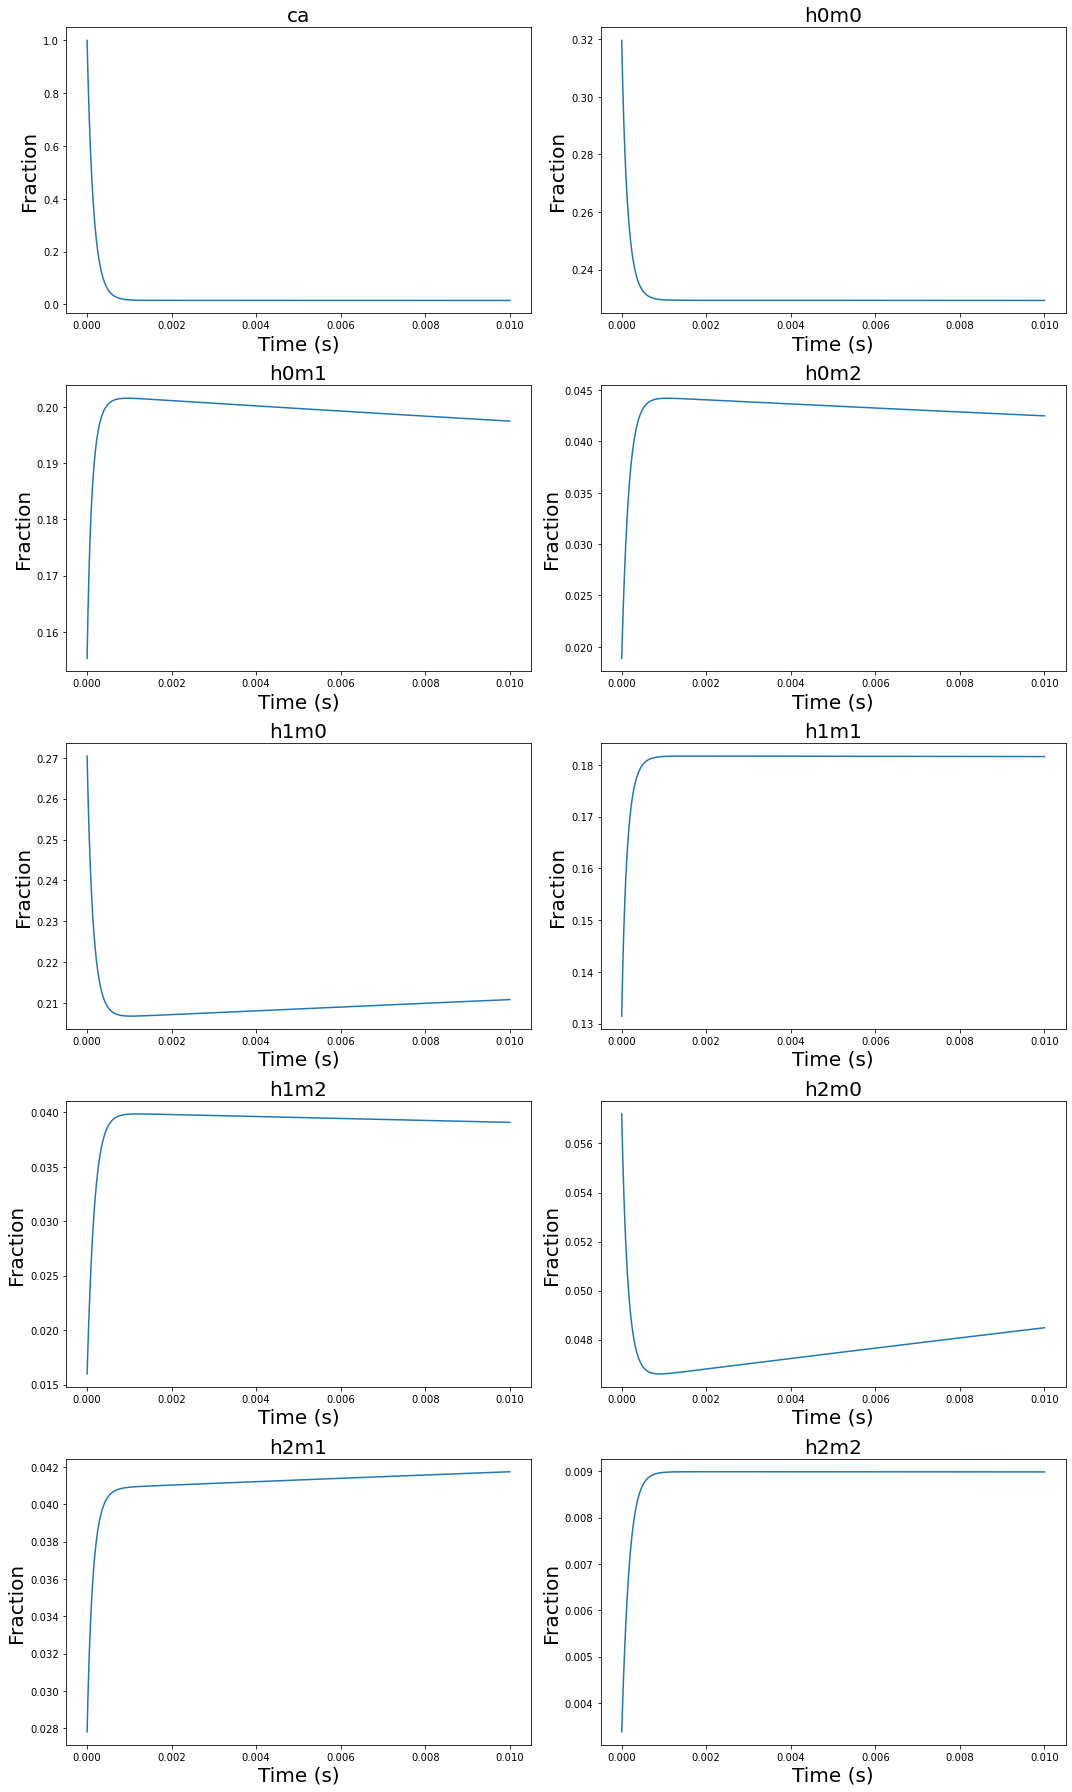

In [35]:
calb_euler()
#%timeit -n 1 -r 10 calb_euler()

### MCell

#### Load and Normalize

In [10]:
# Constants
MCELL_DIR = "/Users/margotwagner/projects/mcell/simple_geom/mini_cylinder_models/"\
            + "model1_cylAxon_calb_files/mcell/output_data/react_data"
SEEDS = 10
DATA_DIM = 2
T_START = 0
ITERATIONS = 5000
T_STEP = 1e-6
T_STOP = ITERATIONS * T_STEP
T_RANGE = np.arange(T_START, T_STOP + T_STEP/2, T_STEP)

# Molecule data file names (ie ca.World.dat)
mol_files = []
mol_names = []
for file_path in glob.glob(os.path.join(MCELL_DIR, "seed_00001/*")):
    mol_file = file_path.split('/')[-1]
    mol_files.append(mol_file)
    mol_names.append(mol_file.split('.')[0])
    
# Initialize data arrays
# Data is list of np arrays n_mol in length
data = []
for i in range(len(mol_files)):
    data.append(np.empty([len(T_RANGE), DATA_DIM, SEEDS]))   # time x features (2 time, val) x seeds

# Add data to all arrays
for seed in range(SEEDS):
    for i in range(len(mol_files)):
        fname = os.path.join(MCELL_DIR, "seed_{:05d}".format(seed+1), mol_files[i])
        data[i][:,:,seed] = pd.read_csv(fname, delim_whitespace=True, header=None)

In [11]:
'''Reorder'''
# Start: ['calb_h0m2', 'calb_h2m1', 'calb_h1m0', 'calb_h2m0', 'calb_h1m1', 
#         'calb_h0m0', 'ca', 'calb_h1m2', 'calb_h2m2', 'calb_h0m1']

# move ca first
# --> ['ca', 'calb_h2m1', 'calb_h1m0', 'calb_h2m0', 'calb_h1m1', 
#      'calb_h0m0', 'calb_h0m2', 'calb_h1m2', 'calb_h2m2', 'calb_h0m1']
data[0], data[6] = data[6], data[0]
mol_names[0], mol_names[6] = mol_names[6], mol_names[0]

# calbindins in order
# --> ['ca', 'calb_h0m0', 'calb_h1m0', 'calb_h2m0', 'calb_h1m1', 
#      'calb_h2m1', 'calb_h0m2', 'calb_h1m2', 'calb_h2m2', 'calb_h0m1']
data[1], data[5] = data[5], data[1]
mol_names[1], mol_names[5] = mol_names[5], mol_names[1]

# --> ['ca', 'calb_h0m0', 'calb_h1m0', 'calb_h2m0', 'calb_h0m1', 
#      'calb_h2m1', 'calb_h0m2', 'calb_h1m2', 'calb_h2m2', 'calb_h1m1']
data[4], data[9] = data[9], data[4]
mol_names[4], mol_names[9] = mol_names[9], mol_names[4]

# --> ['ca', 'calb_h0m0', 'calb_h1m0', 'calb_h2m0', 'calb_h0m1', 
#      'calb_h1m1', 'calb_h0m2', 'calb_h1m2', 'calb_h2m2', 'calb_h2m1']
data[5], data[9] = data[9], data[5]
mol_names[5], mol_names[9] = mol_names[9], mol_names[5]

# --> ['ca', 'calb_h0m0', 'calb_h1m0', 'calb_h2m0', 'calb_h0m1', 
#      'calb_h1m1', 'calb_h1m2', 'calb_h0m2', 'calb_h2m2', 'calb_h2m1']
data[6], data[7] = data[7], data[6]
mol_names[6], mol_names[7] = mol_names[7], mol_names[6]

# --> ['ca', 'calb_h0m0', 'calb_h1m0', 'calb_h2m0', 'calb_h0m1', 
#      'calb_h1m1', 'calb_h2m1', 'calb_h0m2', 'calb_h2m2', 'calb_h1m2']
data[6], data[9] = data[9], data[6]
mol_names[6], mol_names[9] = mol_names[9], mol_names[6]

# --> ['ca', 'calb_h0m0', 'calb_h1m0', 'calb_h2m0', 'calb_h0m1', 
#      'calb_h1m1', 'calb_h2m1', 'calb_h0m2', 'calb_h1m2', 'calb_h2m2']
data[8], data[9] = data[9], data[8]
mol_names[8], mol_names[9] = mol_names[9], mol_names[8]

print(mol_names)

['ca', 'calb_h0m0', 'calb_h1m0', 'calb_h2m0', 'calb_h0m1', 'calb_h1m1', 'calb_h2m1', 'calb_h0m2', 'calb_h1m2', 'calb_h2m2']


In [12]:
'''Normalize'''
CA_IDX = 0

data_norm = np.copy(data)

for mol in range(len(mol_files)):
    for seed in range(SEEDS):
        # ca is at 6th mol index
        if (mol == CA_IDX):
            data_norm[mol][:,1,seed] = data_norm[mol][:,1,seed] / (N_CA_AP + n_ca_base)
         
        # all others calbindin
        else:
            data_norm[mol][:,1,seed] = data_norm[mol][:,1,seed] / (n_calb)

#### Plot

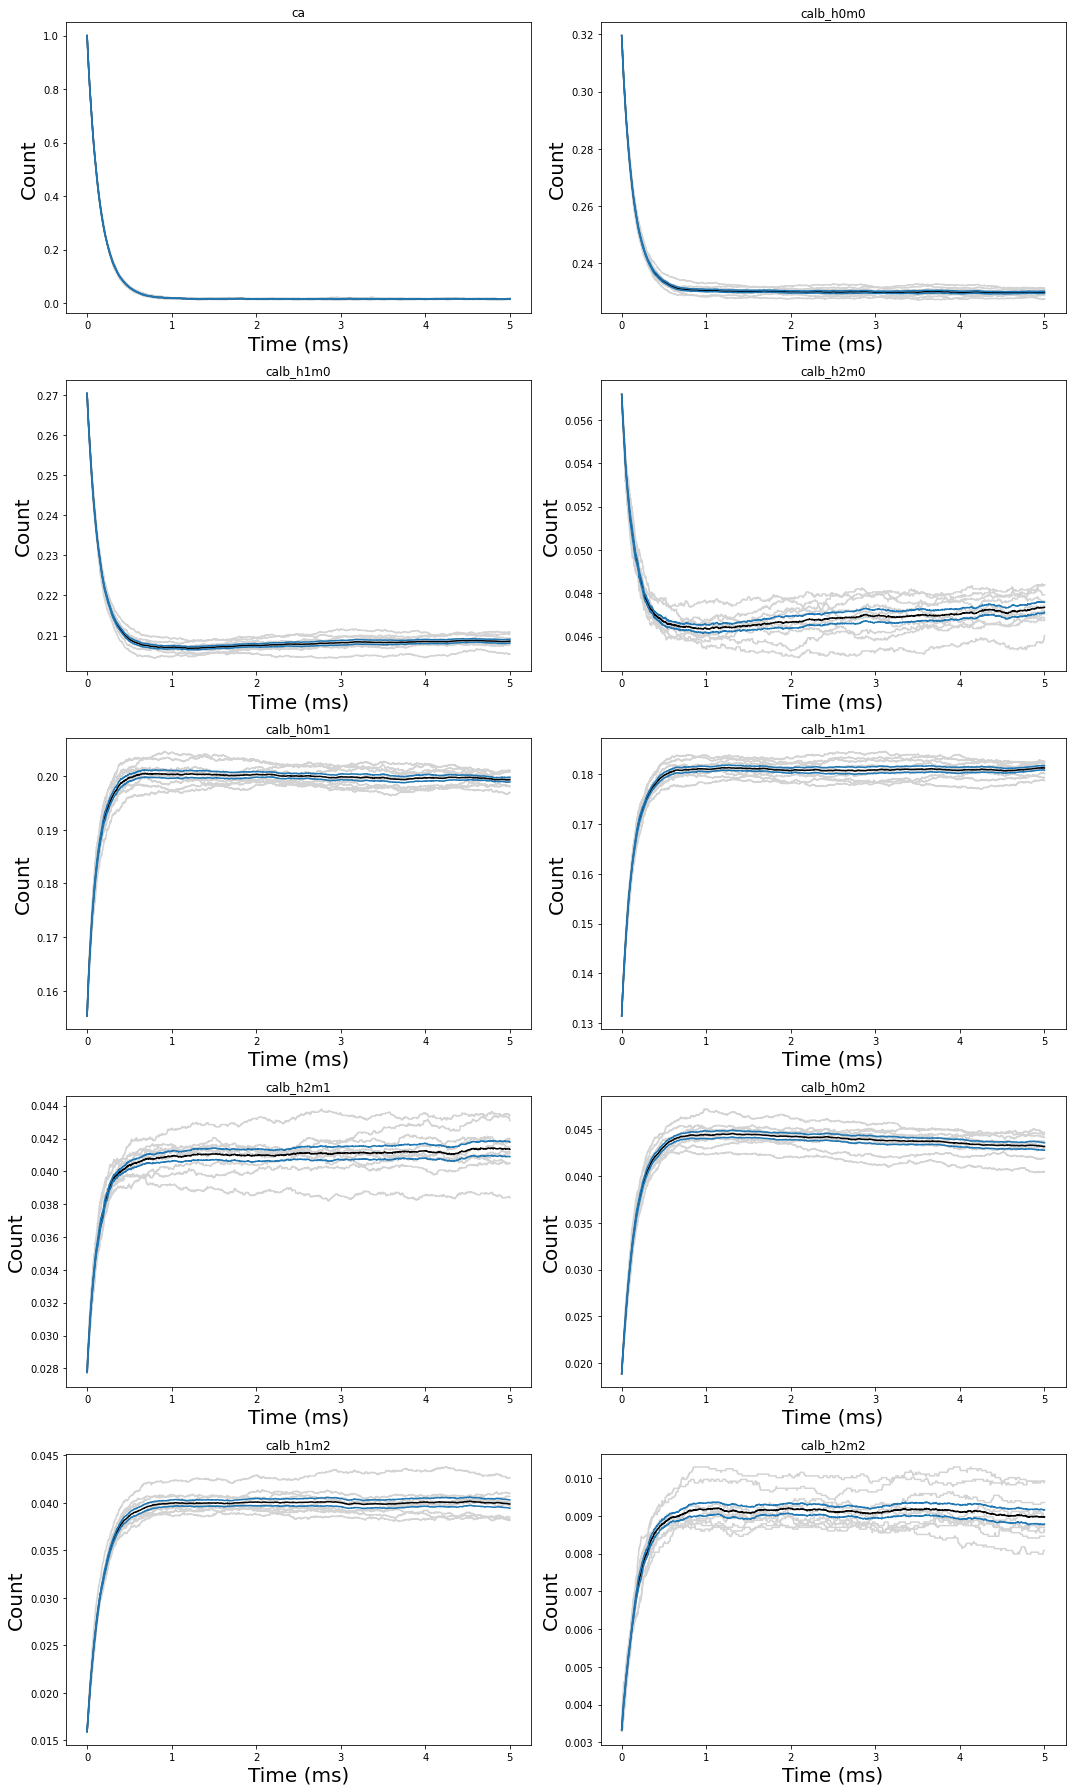

In [13]:
fig, ax = plt.subplots(int(len(mol_files)/2), 2, figsize = (15, 25))

for a, mol in zip(ax.flatten(), range(len(mol_files))):
    for seed in range(SEEDS):
        a.plot(data_norm[mol][:,0,seed]*1000, data_norm[mol][:,1,seed], color='lightgrey')
    mean = np.mean(data_norm[mol], axis=2)
    sem = stats.sem(data_norm[mol], axis=2)
    a.plot(mean[:,0]*1000, mean[:,1], 'k')
    a.plot(mean[:,0]*1000, mean[:,1] + sem[:,1])
    a.plot(mean[:,0]*1000, mean[:,1] - sem[:,1], 'C0')
    a.set_title(mol_names[mol])
    a.set_xlabel('Time (ms)', size=20)
    a.set_ylabel('Count', size=20)

plt.tight_layout()
plt.show()

#TODO: ODES WITH ERROR BARS - Make sure to multiply by [Ca2+]
#TODO: MARKOV MODEL EQUIV - Make sure to multiply by [Ca2+]

### MCell vs ODE

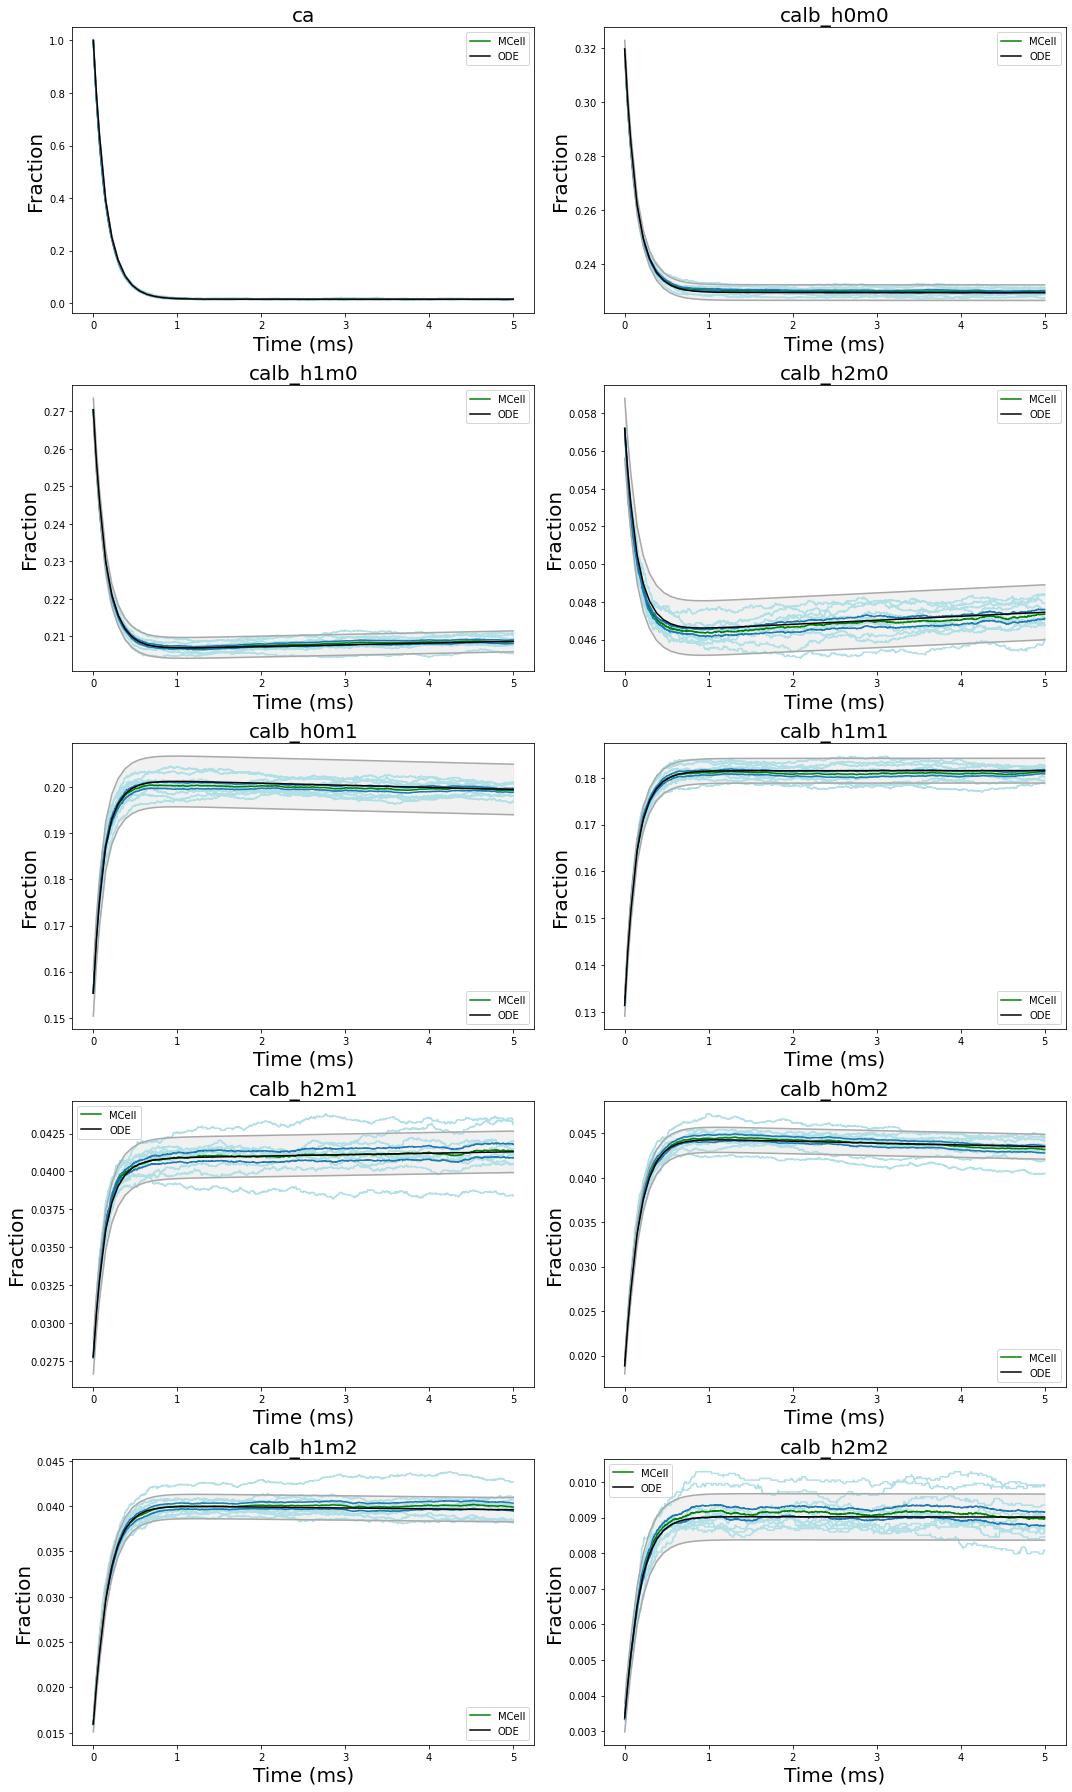

In [14]:
fig, ax = plt.subplots(int(len(mol_files)/2), 2, figsize = (15, 25))

MS_TO_S = 1000
T_IDX = 0
VAL_IDX = 1

# order: ['ca', 'calb_h0m0', 'calb_h1m0', 'calb_h2m0', 'calb_h0m1', 'calb_h1m1', 'calb_h2m1', 'calb_h0m2', 'calb_h1m2', 'calb_h2m2']

'''MCell Trials'''
for a, mol in zip(ax.flatten(), range(len(mol_files))):
    for seed in range(SEEDS):
        a.plot(data_norm[mol][:,0,seed]*MS_TO_S, data_norm[mol][:,1,seed], color='powderblue')
    # Mean
    mean = np.mean(data_norm[mol], axis=2)
    a.plot(mean[:,T_IDX]*MS_TO_S, mean[:,1], color='g', label='MCell', )
    staticmethod
    # SEM
    sem = stats.sem(data_norm[mol], axis=2)
    a.plot(mean[:,T_IDX]*MS_TO_S, mean[:,VAL_IDX] + sem[:,VAL_IDX], 'C0')
    a.plot(mean[:,T_IDX]*MS_TO_S, mean[:,VAL_IDX] - sem[:,VAL_IDX], 'C0')
    
    # Plot labels
    a.set_title(mol_names[mol], size=20)
    a.set_xlabel('Time (ms)', size=20)
    a.set_ylabel('Fraction', size=20)
    a.legend()

'''ODE Solution'''
# Overlay ODE
# ode index equivalents
ODE_IDX = [9, 0, 3, 6, 1, 4, 7, 2, 5, 8]

for a, i in zip(ax.flatten(), ODE_IDX):
    # Std Dev norm factor
    if (i == 1):
        N = n_ca_base + N_CA_AP
    else:
        N = n_calb
        
    # Std dev  
    sd = np.sqrt(np.multiply(calb_sol.y[i,:], (1 - calb_sol.y[i,:]))/N)
    a.plot(calb_sol.t*MS_TO_S, np.add(calb_sol.y[i,:], sd), color='darkgrey')
    a.plot(calb_sol.t*MS_TO_S, np.subtract(calb_sol.y[i,:], sd), color='darkgrey')
    
    # Cloud 
    a.fill_between(calb_sol.t*MS_TO_S, np.add(calb_sol.y[i,:], sd), np.subtract(calb_sol.y[i,:], sd), alpha=0.3,
                  color='lightgrey')
    
    # Mean 
    a.plot(calb_sol.t*MS_TO_S, calb_sol.y[i,:], 'k', label='ODE')
    a.legend()
    
    # Standard error of mean
    #sem = stats.sem(calb_sol.y[i,:])
    #a.plot(calb_sol.t*MS_TO_S, np.add(calb_sol.y[i,:], sem), color='lightgrey', linestyle=':')
    #a.plot(calb_sol.t*MS_TO_S, np.subtract(calb_sol.y[i,:], sem), color='lightgrey', linestyle=':')
    

    
#plt.legend()
plt.tight_layout()
plt.show()


### Markov

Each state has a probability of transition where some are also dependent on the current number of calcium, as seen below. At each time point, there the transition matrix is sampled for each state to determine the states at the next time point. Of note is transitions to less bound states for calbindin include addition of calcium to the system whereas binding decreases calcium in the system.

0, 1, 2, 3, 4, 5, 6, 7 
k_m0m1, k_m1m2, k_m1m0, k_m2m1, k_h0h1, k_h1h2, k_h1h0, k_h2h1  
  
<h1><center>h0m0, h0m1, h0m2, h1m0, h1m1, h1m2, h2m0, h2m1, h2m2</center></h1>
$$\begin{bmatrix} 
\mathbf{1 - \sum} & k_{0}N_{Ca}dt & 0 & k_{4}N_{Ca}dt & 0 & 0 & 0 & 0 & 0 \\ 
k_{2}dt & \mathbf{1 - \sum} & k_{1}N_{Ca}dt & 0 & k_{4}N_{Ca}dt & 0 & 0 & 0 & 0 \\ 
0 & k_{3}dt & \mathbf{1 - \sum} & 0 & 0 & k_{4}N_{Ca}dt & 0 & 0 & 0 \\
k_{6}dt & 0 & 0 & \mathbf{1 - \sum} & k_{0}N_{Ca}dt & 0 & k_{5}N_{Ca}dt & 0 & 0\\
0 & k_{6}dt & 0 & k_{2}dt & \mathbf{1 - \sum} & k_{1}N_{Ca}dt & 0 & k_{5}N_{Ca}dt & 0 \\ 
0 & 0 & k_{6}dt & 0 & k_{3}dt & \mathbf{1 - \sum} & 0 & 0 & k_{5}N_{Ca}dt \\ 
0 & 0 & 0 & k_{7}dt & 0 & 0 & \mathbf{1 - \sum} & k_{0}N_{Ca}dt & 0 \\ 
0 & 0 & 0 & 0 & k_{7}dt & 0 & k_{2}dt & \mathbf{1 - \sum} & k_{1}N_{Ca}dt \\ 
0 & 0 & 0 & 0 & 0 & k_{7}dt & 0 & k_{3}dt & \mathbf{1 - \sum}
\end{bmatrix}$$

Each transition to another state either results in an addition or removal of calcium from the system according to a similar matrix, where each binding event loses a free calcium and each unbinding event gains a calcium. Remaining in the current state has not effect on the total number of calcium.

$$\begin{bmatrix} 
\mathbf{0} & \mathbf{-} & 0 & \mathbf{-} & 0 & 0 & 0 & 0 & 0 \\ 
\mathbf{+} & \mathbf{0} & \mathbf{-} & 0 & \mathbf{-} & 0 & 0 & 0 & 0 \\ 
0 & \mathbf{+} & \mathbf{0} & 0 & 0 & \mathbf{-} & 0 & 0 & 0 \\
\mathbf{+} & 0 & 0 & \mathbf{0} & \mathbf{-} & 0 & \mathbf{-} & 0 & 0\\
0 & \mathbf{+} & 0 & \mathbf{+} & \mathbf{0} & \mathbf{-} & 0 & \mathbf{-} & 0 \\ 
0 & 0 & \mathbf{+} & 0 & \mathbf{+} & \mathbf{0} & 0 & 0 & \mathbf{-} \\ 
0 & 0 & 0 & \mathbf{+} & 0 & 0 & \mathbf{0} & \mathbf{-} & 0 \\ 
0 & 0 & 0 & 0 & \mathbf{+} & 0 & \mathbf{+} & \mathbf{0} & \mathbf{-} \\ 
0 & 0 & 0 & 0 & 0 & \mathbf{+} & 0 & \mathbf{+} & \mathbf{0}
\end{bmatrix}$$

In [15]:
'''Constants'''
AVAGADRO = 6.022e23  # avagadro's number

# Axon dimensions
AXON_R = 0.25        # micron
AXON_L = 4           # micron
MICRON_TO_L = 1e-15  # unit conversion
AXON_VOL = np.pi * (AXON_R ** 2) * AXON_L * MICRON_TO_L  # liters

# Calcium
N_CA_AP = 5275       # action potential
CONC_CA_BASE = 1e-7  # ss calcium concentration
N_CA_BASE = int(round(AXON_VOL * CONC_CA_BASE * AVAGADRO))
N_CA = N_CA_AP + N_CA_BASE

# Calbindin
CONC_CALB = 45e-6    # M
N_CALB = int(round(AXON_VOL * CONC_CALB * AVAGADRO))

In [16]:
def calb_markov(n_calb, n_ca, trange, dt):
    '''
    Simulates a Markov process for the stochastic opening and closing of channels using
    multinomial sampling.

    @param n_calb (int) - number of calbindin to model
    @param n_ca (int) - initial number of calcium
    @param trange (int/float array) - array over which the simulation takes place
    @param dt (int/float) - time step

    @return n_per_state (int array) - number of channels in each state at each time point (shape: [trange, n_states])
    @return ca (int array) - number of calcium that enters at each time point (shape: [trange])
    @return ca_sum (int array) - total sum of calcium that has entered at that time (shape: [trange])
    '''

    '''Constants'''
    idx_t0 = 0  # initial conditions index
    n_states = 9  # number of calbindin states

    '''Transition rates'''
    # From postsynaptic model paper
    two_bind_sites = 2  # factor for two open binding sites
    k_med_forw = 8.7e7  # medium affinity forward binding (1/Ms)
    k_med_rev = 35.8  # medium affinity reverse binding (1/s)
    k_high_forw = 1.1e7  # high affinity forward binding (1/Ms)
    k_high_rev = 2.6  # high affinity reverse binding (1/s)

    # Convert 1/M s to #/s
    k_med_forw = k_med_forw / (AVAGADRO * AXON_VOL)
    k_high_forw = k_high_forw / (AVAGADRO * AXON_VOL)

    # k_m0m1, k_m1m2, k_m1m0, k_m2m1, k_h0h1, k_h1h2, k_h1h0, k_h2h1
    k = [two_bind_sites * k_med_forw,  # k[0] = k_M0M1
         k_med_forw,  # k[1] = k_M1M2
         k_med_rev,  # k[2] = k_M1M0
         two_bind_sites * k_med_rev,  # k[3] = k_M2M1
         two_bind_sites * k_high_forw,  # k[4] = k_H0H1
         k_high_forw,  # k[5] = k_H1H2
         k_high_rev,  # k[6] = k_H1H0
         two_bind_sites * k_high_rev]  # k[7] = k_H2H1

    '''Effect of transitions on calcium'''
    delta_ca = np.zeros((n_states, n_states))
    n_state_cols = 3
    ca_loss = -1
    ca_gain = 1
    off_center_shift = 1
    no_remain = 0

    for row in range(n_states):
        for col in range(n_states):
            if (row + n_state_cols) < n_states:
                delta_ca[row, row + n_state_cols] = ca_loss
                delta_ca[row + n_state_cols, row] = ca_gain
            if (row + off_center_shift) < n_states and (row + off_center_shift) % n_state_cols != no_remain:
                delta_ca[row, row + off_center_shift] = ca_loss
                delta_ca[row + off_center_shift, row] = ca_gain

    '''Set initial conditions for all states'''
    # Initializing states
    n_per_state = np.zeros((len(trange), n_states), dtype=int)
    ca = np.zeros(len(trange), dtype=int)

    # Initial amount of calbindin
    # Channels start in ss
    # h0m0,  h0m1,  h0m2,  h1m0,  h1m1,  h1m2,  h2m0,  h2m1,  h2m2
    #   0     1      2      3      4      5      6      7      8
    calb_frac = np.array([0.31958713, 0.15533006, 0.0188739,
                          0.27041988, 0.13143312, 0.01597023,
                          0.0572042, 0.02780316, 0.00337832])  # initial fraction of each calb

    n_per_state[idx_t0, :] = n_calb * calb_frac
    #print("Starting calbindin states:", n_per_state[idx_t0, :])

    # Initial amount of calcium
    ca[idx_t0] = n_ca
    #print("Starting calcium number:", ca[idx_t0])

    '''Simulation'''
    step = 1
    # All time points except initial state
    for t_i in range(len(trange) - 1):
        # k_m0m1, k_m1m2, k_m1m0, k_m2m1, k_h0h1, k_h1h2, k_h1h0, k_h2h1
        #    0      1        2        3      4       5       6       7

        p = np.array(
            [[1 - (k[0] * ca[t_i] * dt + k[4] * ca[t_i] * dt), k[0] * ca[t_i] * dt, 0, k[4] * ca[t_i] * dt, 0,
              0, 0, 0, 0],

             [k[2] * dt, 1 - (k[2] * dt + k[1] * ca[t_i] * dt + k[4] * ca[t_i] * dt), k[1] * ca[t_i] * dt, 0,
              k[4] * ca[t_i] * dt, 0, 0, 0, 0],

             [0, k[3] * dt, 1 - (k[3] * dt + k[4] * ca[t_i] * dt), 0, 0, k[4] * ca[t_i] * dt, 0, 0, 0],

             [k[6] * dt, 0, 0, 1 - (k[6] * dt + k[0] * ca[t_i] * dt + k[5] * ca[t_i] * dt),
              k[0] * ca[t_i] * dt, 0, k[5] * ca[t_i] * dt, 0, 0],

             [0, k[6] * dt, 0, k[2] * dt,
              1 - (k[6] * dt + k[2] * dt + k[1] * ca[t_i] * dt + k[5] * ca[t_i] * dt), k[1] * ca[t_i] * dt, 0,
              k[5] * ca[t_i] * dt, 0],

             [0, 0, k[6] * dt, 0, k[3] * dt, 1 - (k[6] * dt + k[3] * dt + k[5] * ca[t_i] * dt), 0, 0,
              k[5] * ca[t_i] * dt],

             [0, 0, 0, k[7] * dt, 0, 0, 1 - (k[7] * dt + k[0] * ca[t_i] * dt), k[0] * ca[t_i] * dt, 0],

             [0, 0, 0, 0, k[7] * dt, 0, k[2] * dt, 1 - (k[7] * dt + k[2] * dt + k[1] * ca[t_i] * dt),
              k[1] * ca[t_i] * dt],

             [0, 0, 0, 0, 0, k[7] * dt, 0, k[3] * dt, 1 - (k[7] * dt + k[3] * dt)]])

        # Samples from multinomial distribution
        # the drawn samples = np.random.multinomial(n experiments, (p)robabilities)
        # determine the number at the next time point
        sample = np.zeros((n_states, n_states))

        # Draw a transition sample from each state
        for i in range(n_states):
            sample[i, :] = np.random.multinomial(n_per_state[t_i, i], p[i])

        # Sum samples for each state from all states to get total number of calbindin
        # in each state at the next time point
        n_per_state[t_i + step, :] = np.sum(sample, axis=0)

        # Multiple sample by calcium change matrix and sum all calcium changes to get overall change
        ca[t_i + step] = ca[t_i] + np.sum(np.multiply(sample, delta_ca))

    return n_per_state, ca


[0.000e+00 1.000e-06 2.000e-06 ... 4.999e-03 5.000e-03 5.001e-03]


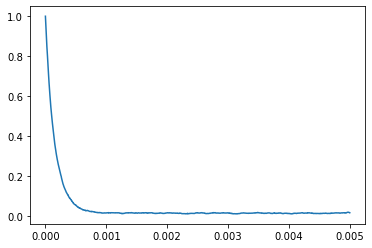

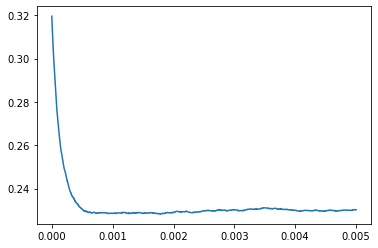

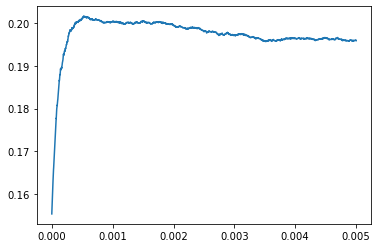

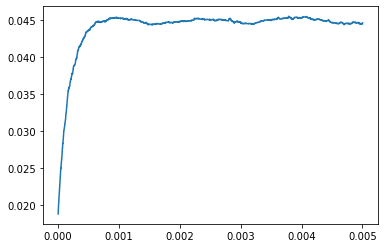

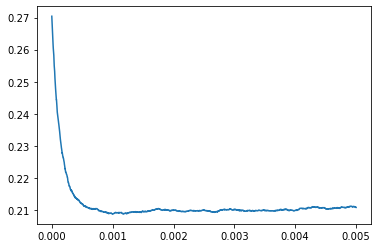

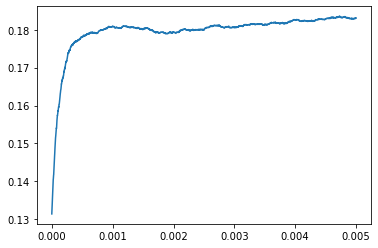

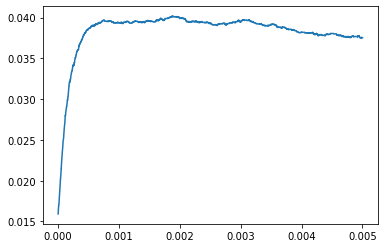

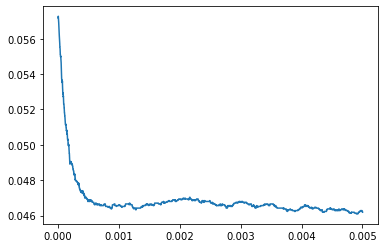

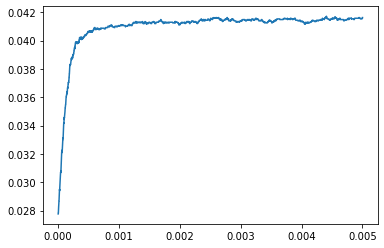

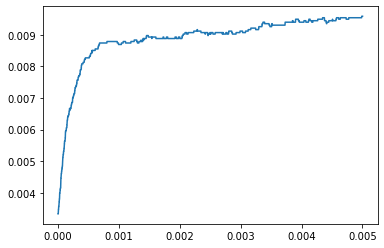

In [17]:
dt = 1e-6
t_stop = 5e-3
t_start = 0
t_range = np.arange(t_start, t_stop + dt, dt)
print(t_range)
n_per_state, ca = calb_markov(N_CALB, N_CA, t_range, dt)

ca = ca / N_CA
n_per_state = n_per_state/N_CALB

plt.figure()
plt.plot(t_range, ca)

for i in range(n_per_state.shape[1]):
    plt.figure()
    plt.plot(t_range, n_per_state[:,i])

plt.show()

## Run Markov 1000 Times

In [54]:
# Constants
n_runs = 1000
n_calb_states = 9

# Time array
dt = 1e-6
t_stop = 5e-3
t_start = 0
t_range = np.arange(t_start, t_stop + dt, dt)

# Initialize array sizes
ca = np.empty([len(t_range), n_runs])
calb_states = np.empty([len(t_range), n_calb_states, n_runs])

In [55]:
# Run simulation
for i in range(n_runs):
    calb_states[:, :, i], ca[:, i] = calb_markov(N_CALB, N_CA, t_range, dt)

In [57]:
# trial number for each time point
trial = np.empty(n_runs*len(t_range))

for run in range(n_runs):
    for tp in range(len(t_range)):
        trial[len(t_range)*run + tp] = run + 1
        
# repeat timepoints for each trial
timepoints = np.tile(t_range, n_runs)

In [67]:
markov_results = pd.DataFrame(trial, columns=['trial'])
markov_results['timepoints'] = timepoints
k = 0
for i in range(3):
    for j in range(3):
        markov_results['h{0}m{1}'.format(j, i)] = calb_states[:, k, :].flatten('F')
        k += 1
markov_results['ca'] = ca.flatten('F')

In [68]:
markov_results.head()

,trial,timepoints,h0m0,h0m1,h0m2,h1m0,h1m1,h1m2,h2m0,h2m1,h2m2,ca
0,1.0,0.000000,6802.0,3306.0,401.0,5755.0,2797.0,339.0,1217.0,591.0,71.0,5322.0
1,1.0,0.000001,6790.0,3309.0,406.0,5746.0,2807.0,341.0,1217.0,591.0,72.0,5288.0
2,1.0,0.000002,6778.0,3316.0,409.0,5735.0,2817.0,344.0,1215.0,591.0,74.0,5253.0
3,1.0,0.000003,6765.0,3323.0,411.0,5725.0,2829.0,345.0,1215.0,592.0,74.0,5222.0
4,1.0,0.000004,6744.0,3337.0,415.0,5717.0,2836.0,348.0,1212.0,594.0,76.0,5177.0


In [69]:
markov_results.shape

(5002000, 12)

In [71]:
from math import ceil

MAX_STORE = 1000000

# Save data
for i in range(int(ceil(markov_results.shape[0]/MAX_STORE))):
    # Save to csv
    markov_results.iloc[i*MAX_STORE:(i+1)*MAX_STORE].to_csv('calb_markov_1000_runs_{:d}.csv'.format(i), index=False)

In [75]:
markov_results['ca_norm'] = markov_results['ca']/N_CA
for col_name in markov_results.columns[2:11]:
    markov_results['{}_norm'.format(col_name)] = markov_results[col_name]/N_CALB
    
markov_results.head()


,trial,timepoints,h0m0,h0m1,h0m2,h1m0,h1m1,h1m2,h2m0,h2m1,...,h0m0_norm,h0m1_norm,h0m2_norm,h1m0_norm,h1m1_norm,h1m2_norm,h2m0_norm,h2m1_norm,h2m2_norm,ca_norm
0,1.0,0.000000,6802.0,3306.0,401.0,5755.0,2797.0,339.0,1217.0,591.0,...,0.319583,0.155328,0.018840,0.270391,0.131413,0.015927,0.057179,0.027767,0.003336,1.000000
1,1.0,0.000001,6790.0,3309.0,406.0,5746.0,2807.0,341.0,1217.0,591.0,...,0.319019,0.155469,0.019075,0.269968,0.131883,0.016021,0.057179,0.027767,0.003383,0.993611
2,1.0,0.000002,6778.0,3316.0,409.0,5735.0,2817.0,344.0,1215.0,591.0,...,0.318455,0.155798,0.019216,0.269451,0.132353,0.016162,0.057085,0.027767,0.003477,0.987035
3,1.0,0.000003,6765.0,3323.0,411.0,5725.0,2829.0,345.0,1215.0,592.0,...,0.317844,0.156127,0.019310,0.268981,0.132917,0.016209,0.057085,0.027814,0.003477,0.981210
4,1.0,0.000004,6744.0,3337.0,415.0,5717.0,2836.0,348.0,1212.0,594.0,...,0.316858,0.156784,0.019498,0.268606,0.133246,0.016350,0.056944,0.027908,0.003571,0.972755


## Load Markov data

In [18]:
##########################
###### MARKOV DATA #######
##########################
def markov_sim(fname):
    sep_results_df = (pd.read_csv(file) for file in sorted(glob.glob(fname)))
    markov_results = pd.concat(sep_results_df)

    # Normalize
    markov_results['ca_norm'] = markov_results['ca']/N_CA
    for col_name in markov_results.columns[2:11]:
        markov_results['{}_norm'.format(col_name)] = markov_results[col_name]/N_CALB
        
    # Average across trials
    avg_markov_results = markov_results.groupby('timepoints').mean()
    del avg_markov_results['trial']
        
    markov_results.head()
    
    return markov_results, avg_markov_results

In [20]:
fname = "../markov_data/calb_markov_1000_runs*.csv"
markov_results = markov_sim(fname)

In [22]:
markov_results.head()

AttributeError: 'tuple' object has no attribute 'head'

In [19]:
fname = "../markov_data/calb_markov_1000_runs*.csv"
sep_results_df = (pd.read_csv(file) for file in sorted(glob.glob(fname)))
markov_results = pd.concat(sep_results_df)


In [20]:
markov_results.columns = ['trial', 'timepoints', 'h0m0', 'h1m0', 'h2m0', 'h0m1', 'h1m1', 'h2m1', 'h0m2', 'h1m2', 'h2m2', 'ca']
markov_results.head()

,trial,timepoints,h0m0,h1m0,h2m0,h0m1,h1m1,h2m1,h0m2,h1m2,h2m2,ca
0,1.0,0.000000,6802.0,3306.0,401.0,5755.0,2797.0,339.0,1217.0,591.0,71.0,5322.0
1,1.0,0.000001,6790.0,3309.0,406.0,5746.0,2807.0,341.0,1217.0,591.0,72.0,5288.0
2,1.0,0.000002,6778.0,3316.0,409.0,5735.0,2817.0,344.0,1215.0,591.0,74.0,5253.0
3,1.0,0.000003,6765.0,3323.0,411.0,5725.0,2829.0,345.0,1215.0,592.0,74.0,5222.0
4,1.0,0.000004,6744.0,3337.0,415.0,5717.0,2836.0,348.0,1212.0,594.0,76.0,5177.0


In [21]:
markov_results['ca_norm'] = markov_results['ca']/N_CA
for col_name in markov_results.columns[2:11]:
    markov_results['{}_norm'.format(col_name)] = markov_results[col_name]/N_CALB

In [22]:
markov_results.head()

,trial,timepoints,h0m0,h1m0,h2m0,h0m1,h1m1,h2m1,h0m2,h1m2,...,ca_norm,h0m0_norm,h1m0_norm,h2m0_norm,h0m1_norm,h1m1_norm,h2m1_norm,h0m2_norm,h1m2_norm,h2m2_norm
0,1.0,0.000000,6802.0,3306.0,401.0,5755.0,2797.0,339.0,1217.0,591.0,...,1.000000,0.319583,0.155328,0.018840,0.270391,0.131413,0.015927,0.057179,0.027767,0.003336
1,1.0,0.000001,6790.0,3309.0,406.0,5746.0,2807.0,341.0,1217.0,591.0,...,0.993611,0.319019,0.155469,0.019075,0.269968,0.131883,0.016021,0.057179,0.027767,0.003383
2,1.0,0.000002,6778.0,3316.0,409.0,5735.0,2817.0,344.0,1215.0,591.0,...,0.987035,0.318455,0.155798,0.019216,0.269451,0.132353,0.016162,0.057085,0.027767,0.003477
3,1.0,0.000003,6765.0,3323.0,411.0,5725.0,2829.0,345.0,1215.0,592.0,...,0.981210,0.317844,0.156127,0.019310,0.268981,0.132917,0.016209,0.057085,0.027814,0.003477
4,1.0,0.000004,6744.0,3337.0,415.0,5717.0,2836.0,348.0,1212.0,594.0,...,0.972755,0.316858,0.156784,0.019498,0.268606,0.133246,0.016350,0.056944,0.027908,0.003571


In [23]:
avg_markov_results = markov_results.groupby('timepoints').mean()
del avg_markov_results['trial']

In [24]:
avg_markov_results.head()

,h0m0,h1m0,h2m0,h0m1,h1m1,h2m1,h0m2,h1m2,h2m2,ca,ca_norm,h0m0_norm,h1m0_norm,h2m0_norm,h0m1_norm,h1m1_norm,h2m1_norm,h0m2_norm,h1m2_norm,h2m2_norm
timepoints,,,,,,,,,,,,,,,,,,,,
0.000000,6802.000,3306.000,401.000,5755.000,2797.000,339.000,1217.000,591.000,71.000,5322.000,1.000000,0.319583,0.155328,0.018840,0.270391,0.131413,0.015927,0.057179,0.027767,0.003336
0.000001,6787.463,3314.883,404.096,5744.697,2805.989,341.813,1215.348,593.091,71.620,5285.362,0.993116,0.318900,0.155745,0.018986,0.269907,0.131836,0.016060,0.057101,0.027866,0.003365
0.000002,6772.892,3323.819,407.152,5734.395,2815.017,344.584,1213.651,595.285,72.205,5248.719,0.986231,0.318215,0.156165,0.019129,0.269423,0.132260,0.016190,0.057022,0.027969,0.003392
0.000003,6758.442,3332.663,410.228,5724.404,2823.680,347.361,1211.914,597.478,72.830,5212.452,0.979416,0.317536,0.156581,0.019274,0.268953,0.132667,0.016320,0.056940,0.028072,0.003422
0.000004,6744.087,3341.521,413.226,5714.468,2832.349,350.092,1210.183,599.660,73.414,5176.583,0.972676,0.316862,0.156997,0.019415,0.268487,0.133074,0.016449,0.056859,0.028174,0.003449


# Comparison

In [25]:
def comparison():
    with plt.style.context('seaborn'):
        fig, ax = plt.subplots(int(len(mol_files)/2), 2, figsize = (15, 25))
    
    MS_TO_S = 1000
    T_IDX = 0
    VAL_IDX = 1
    lwidth = 3
    
    # order: ['ca', 'calb_h0m0', 'calb_h1m0', 'calb_h2m0', 'calb_h0m1', 'calb_h1m1', 'calb_h2m1', 'calb_h0m2', 'calb_h1m2', 'calb_h2m2']
    
    '''MCell Trials'''
    for a, mol in zip(ax.flatten(), range(len(mol_files))):
        #for seed in range(SEEDS):
        #    a.plot(data_norm[mol][:,0,seed]*MS_TO_S, data_norm[mol][:,1,seed], color='powderblue')
        # Mean
        mcell_color = 'C3'
        mcell_mean = np.mean(data_norm[mol], axis=2)
        mcell_std = np.std(data_norm[mol], axis=2)
        a.plot(mcell_mean[:,T_IDX]*MS_TO_S, mcell_mean[:,1], color=mcell_color, label='MCell', linewidth=lwidth)
        
        # SEM
        #sem = stats.sem(data_norm[mol], axis=2)
        #a.plot(mean[:,T_IDX]*MS_TO_S, mean[:,VAL_IDX] + sem[:,VAL_IDX], 'C0')
        #a.plot(mean[:,T_IDX]*MS_TO_S, mean[:,VAL_IDX] - sem[:,VAL_IDX], 'C0')
        
        # Cloud plot for std dev
        a.fill_between(mean[:,T_IDX]*MS_TO_S, np.add(mcell_mean[:,1], mcell_std[:,1]), 
                       np.subtract(mcell_mean[:,1], mcell_std[:,1]),alpha=0.3, color=mcell_color) 
        
    '''Markov Solution'''
    #h0m0,  h0m1,  h0m2,  h1m0,  h1m1,  h1m2,  h2m0,  h2m1,  h2m2
    #  0,     1.    2.      3.     4.    5.     6.      7.     8  
    MARKOV_IDX = [9, 0, 3, 6, 1, 4, 7, 2, 5, 8]
    for a, i in zip(ax.flatten(), MARKOV_IDX):
        if (i == 9):
            a.plot(t_range*1000, ca)
        else:
            a.plot(t_range*1000, n_per_state[:,i])
    
    
    '''ODE Solution'''
    # Overlay ODE
    # ode index equivalents
    ODE_IDX = [9, 0, 3, 6, 1, 4, 7, 2, 5, 8]
    
    for a, i in zip(ax.flatten(), ODE_IDX):
        # Std Dev norm factor
        if (i == 1):
            N = N_CA
        else:
            N = N_CALB
            
        # Std dev  
        sd = np.sqrt(np.multiply(calb_sol.y[i,:], (1 - calb_sol.y[i,:]))/N)
        a.plot(calb_sol.t*MS_TO_S, np.add(calb_sol.y[i,:], sd), color='darkgrey')
        a.plot(calb_sol.t*MS_TO_S, np.subtract(calb_sol.y[i,:], sd), color='darkgrey')
        
        # Cloud 
        a.fill_between(calb_sol.t*MS_TO_S, np.add(calb_sol.y[i,:], sd), np.subtract(calb_sol.y[i,:], sd), alpha=0.3,
                      color='lightgrey')
        
        # Mean 
        a.plot(calb_sol.t*MS_TO_S, calb_sol.y[i,:], 'k', label='ODE')
        a.legend()
        
        # Standard error of mean
        #sem = stats.sem(calb_sol.y[i,:])
        #a.plot(calb_sol.t*MS_TO_S, np.add(calb_sol.y[i,:], sem), color='lightgrey', linestyle=':')
        #a.plot(calb_sol.t*MS_TO_S, np.subtract(calb_sol.y[i,:], sem), color='lightgrey', linestyle=':')
        
        
        
        # Plot labels
        a.set_title(mol_names[mol], size=20)
        a.set_xlabel('Time (ms)', size=20)
        a.set_ylabel('Fraction', size=20)
        a.legend()
        
    
        
    #plt.legend()
    #plt.tight_layout()
    #plt.show()

## PMCA binding

<img src="./figs/pmca_kinetics.png" width="200"> <img src="./figs/pmca_eqtns.png" width="200">

**Equations**
$$ 
\frac{dP0}{dt} 
= -k_1[Ca][P0] + (k_2 + k_3)[P1]
$$
$$ 
\frac{dP1}{dt} 
= k_1[Ca][P0] - (k_2 + k_3)[P1]
$$
$$ 
\frac{dCa}{dt} 
= -k_1[Ca][P0] + k_2[P1] + k_{leak}([P0] + [P1])
$$


In [8]:
'''PMCA concentrations as constant number'''
PMCA_DENSITY = 180   # number per um^2
PMCA_BOUND_FRAC = 0.357  # % of pmca initially bound

# find axon surface area
axon_sa_um2 = 2*math.pi*AXON_RAD*AXON_LEN    # micron^2 (not on end caps)

# convert surface density to constant numbers
n_pmca = int(round(axon_sa_um2 * PMCA_DENSITY))


print(n_pmca)

1131


### ODEs

#### solve_ivp

In [9]:
from scipy.integrate import solve_ivp
def pmca_odes(t, y):
    '''
     ODEs to describe pmca kinetics according to Bartol et al (2015)
     input:        y:        array of pmca and calcium concentrations (arr, 3 x 1)
     output:       eqtns:       system of odes to describe pmca
     '''
    
    # k_values meaning
    k_1 = 1.5e8    # ca binding and removal (M/s)
    K_1 = (k_1*AVAGADRO*axon_vol)  # number Ca/s # number /( s*vol)
    K_2 = 15       # ca unbinding (/s)
    K_3 = 12       # pmca reset (/s)
    K_LEAK = 4.3   # calcium inward leak (/s)
    
    # Unpack input
    p0, p1, ca = y    # unbound/bound densities and calcium
    
    # System of ODEs
    eqtns = []
    
    # d(p0)/dt
    eqtns.append(-K_1*p0*ca + (K_2 + K_3)*p1)
    
    # d(p1)/dt
    eqtns.append(K_1*p0*ca - (K_2 + K_3)*p1)
    
    # d(ca)/dt
    eqtns.append(-K_1*p0*ca + K_2*p1 + K_LEAK*(p0 + p1))
    
    #return eqtns
    return eqtns

In [10]:
# Can do initial concentration or initial number
# p0, p1, ca 
# Count here
y0 = [int(round(n_pmca * (1 - PMCA_BOUND_FRAC))),
      int(round(n_pmca * PMCA_BOUND_FRAC)),
      n_ca_base + N_CA_AP ]

## Initial concentrations
# number/(s * vol)

#y0 = [PMCA_DENSITY * (1 - PMCA_BOUND_FRAC),
#      PMCA_DENSITY * PMCA_BOUND_FRAC,
#      conc_ca ]

print(y0)

pmca_sol = solve_ivp(pmca_odes, [T_START, T_STOP] , y0, method='LSODA')

[727, 404, 5322]


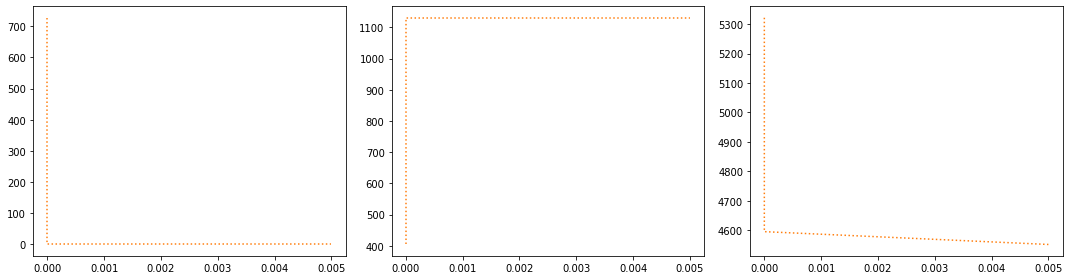

In [11]:
fig, ax = plt.subplots(1, 3, figsize = (15,4))

for a, i in zip(ax.flatten(), range(3)):
    a.plot(pmca_sol.t, pmca_sol.y[i,:], color='C1', linestyle = ':')
    
plt.tight_layout()
plt.show()

#### odeint

In [55]:
from scipy.integrate import odeint
def pmca_odes(t, y):
    '''
     ODEs to describe pmca kinetics according to Bartol et al (2015)
     input:        y:        array of pmca and calcium concentrations (arr, 3 x 1)
     output:       eqtns:       system of odes to describe pmca
     '''
    
    # k_values meaning
    K_1 = 1.5e8    # ca binding and removal
    K_2 = 15       # ca unbinding
    K_3 = 12       # pmca reset
    K_LEAK = 4.3   # calcium inward leak
    
    # Unpack input
    p0, p1, ca = y    # unbound/bound densities and calcium
    
    # System of ODEs
    eqtns = []
    
    # d(p0)/dt
    eqtns.append(-K_1*p0*ca + (K_2 + K_3)*p1)
    
    # d(p1)/dt
    eqtns.append(K_1*p0*ca - (K_2 + K_3)*p1)
    
    # d(ca)/dt
    eqtns.append(-K_1*p0*ca + K_LEAK*(p0 + p1))
    
    return [-K_1*p0*ca + (K_2 + K_3)*p1, K_1*p0*ca - (K_2 + K_3)*p1, -K_1*p0*ca + K_LEAK*(p0 + p1)]

In [59]:
'''odeint'''

# Can do initial concentration or initial number
# p0, p1, ca 
# Count here
y0 = np.array([int(round(n_pmca * (1 - PMCA_BOUND_FRAC))),
      int(round(n_pmca * PMCA_BOUND_FRAC)),
      n_ca_base + N_CA_AP] )

print(y0)

pmca_sol = odeint(pmca_odes, y0, T_RANGE)

[ 727  404 5322]


TypeError: cannot unpack non-iterable float object

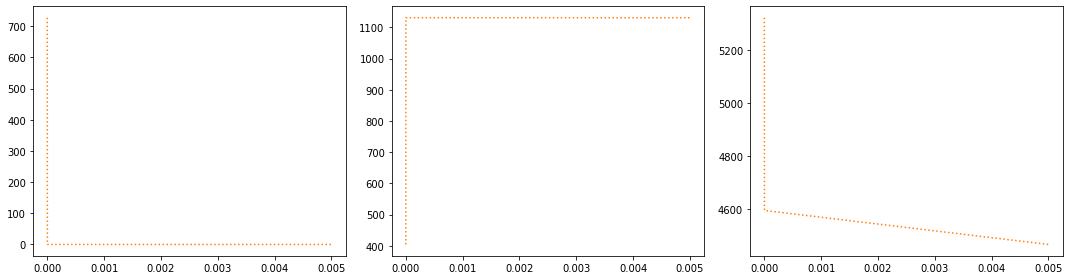

In [64]:
fig, ax = plt.subplots(1, 3, figsize = (15,4))

for a, i in zip(ax.flatten(), range(3)):
    a.plot(pmca_sol.t, pmca_sol.y[i,:], color='C1', linestyle = ':')
    
plt.tight_layout()
plt.show()

### PMCA Surface MCell

In [12]:
# Constants
MCELL_DIR = "/Users/margotwagner/projects/mcell/simple_geom/model1_cylAxon_pmca_files/mcell/output_data/react_data/"
SEEDS = 10
DATA_DIM = 2
T_START = 0
ITERATIONS = 5000
T_STEP = 1e-6
T_STOP = ITERATIONS * T_STEP
T_RANGE = np.arange(T_START, T_STOP + T_STEP/2, T_STEP)

# Molecule data file names (ie ca.World.dat) - can also be reactions here!
mol_files = []
mol_names = []
for file_path in glob.glob(os.path.join(MCELL_DIR, "seed_00001/*")):
    mol_file = file_path.split('/')[-1]
    mol_files.append(mol_file)
    mol_names.append(mol_file.split('.')[0])
    
# Initialize data arrays
data = []
for i in range(len(mol_files)):
    data.append(np.empty([len(T_RANGE), DATA_DIM, SEEDS]))

# Add data to all arrays
for seed in range(SEEDS):
    for i in range(len(mol_files)):
        fname = os.path.join(MCELL_DIR, "seed_{:05d}".format(seed+1), mol_files[i])
        data[i][:,:,seed] = pd.read_csv(fname, delim_whitespace=True, header=None)

In [13]:
'''Reorder'''
# Currently: ['reset', 'pmca_p0', 'pmca_p1', 'leak_p1', 'unbinding', 'ca', 'leak_p0', 'removal']

# pmca_p0 first
# --> ['pmca_p0', 'reset', 'pmca_p1', 'leak_p1', 'unbinding', 'ca', 'leak_p0', 'removal']
data[0], data[1] = data[1], data[0]
mol_names[0], mol_names[1] = mol_names[1], mol_names[0]

# pmca_p1 second
# --> ['pmca_p0', 'pmca_p1', 'reset', 'leak_p1', 'unbinding', 'ca', 'leak_p0', 'removal']
data[1], data[2] = data[2], data[1]
mol_names[1], mol_names[2] = mol_names[2], mol_names[1]

# ca third
# --> ['pmca_p0', 'pmca_p1', 'ca', 'leak_p1', 'unbinding', 'reset', 'leak_p0', 'removal']
data[2], data[5] = data[5], data[2]
mol_names[2], mol_names[5] = mol_names[5], mol_names[2]

# removal fourth
# --> ['pmca_p0', 'pmca_p1', 'ca', 'removal', 'unbinding', 'reset', 'leak_p0', 'leak_p1']
data[3], data[7] = data[5], data[7]
mol_names[3], mol_names[7] = mol_names[7], mol_names[3]


In [14]:
'''Normalize'''

# CHANGES DATA AND DATA_NORM...
data_norm = np.copy(data)

for mol in range(len(mol_files)):
    for seed in range(SEEDS):
        # top two are pmca
        if (mol < 2):
            data_norm[mol][:,1,seed] = data_norm[mol][:,1,seed] / (n_pmca)
         
        # third is calcium
        elif (mol == 2):
            data_norm[mol][:,1,seed] = data_norm[mol][:,1,seed] / (N_CA_AP + n_ca_base)

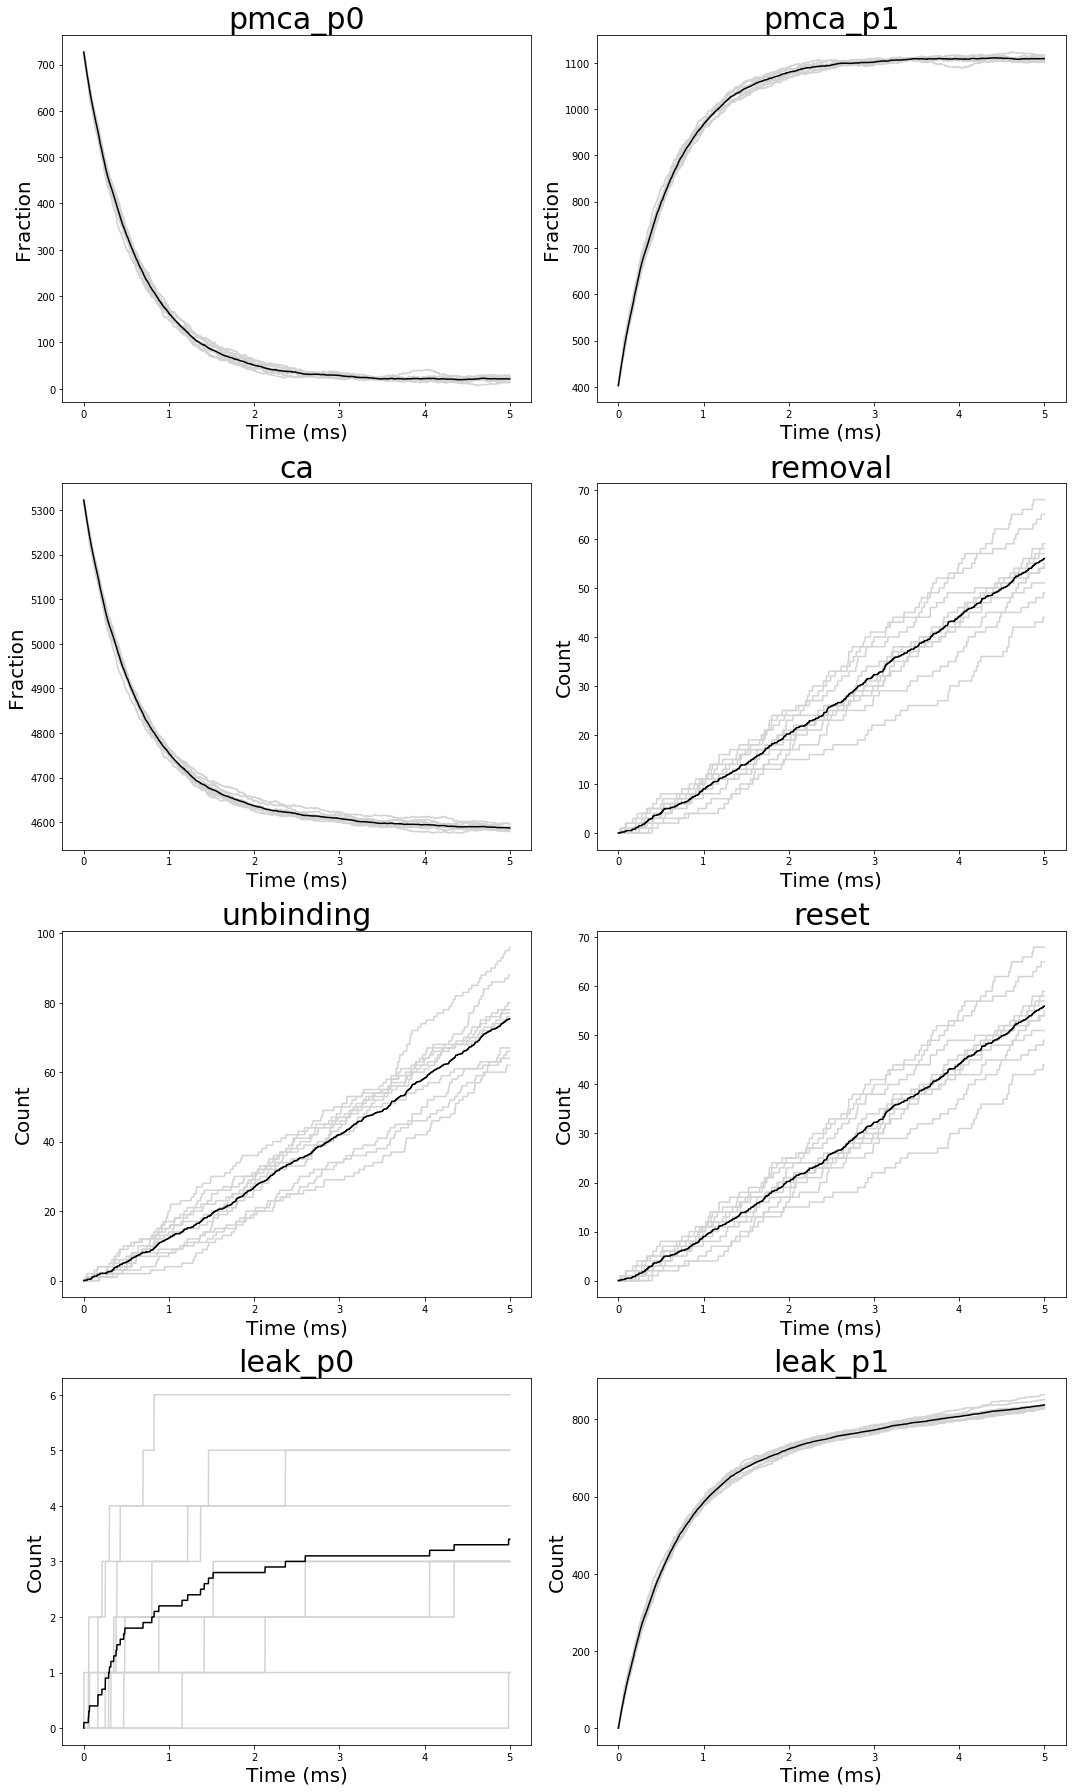

In [5]:
fig, ax = plt.subplots(int(len(mol_files)/2), 2, figsize = (15, 25))

for a, mol in zip(ax.flatten(), range(len(mol_files))):
    for seed in range(SEEDS):
        a.plot(data_norm[mol][:,0,seed]*1000, data_norm[mol][:,1,seed], color='lightgrey')
    mean = np.mean(data_norm[mol], axis=2)
    a.plot(mean[:,0]*1000, mean[:,1], 'k')
    a.set_title(mol_names[mol], size=30)
    a.set_xlabel('Time (ms)', size=20)
    if (mol <= 2):
        a.set_ylabel('Fraction', size=20)
    else:
        a.set_ylabel('Count', size=20)

plt.tight_layout()
plt.show()

### PMCA Volume MCell Model

In [22]:
# Constants
MCELL_DIR = "/Users/margotwagner/projects/mcell/simple_geom/model1_cylAxon_pmca_vol_files/mcell/output_data/react_data/"
SEEDS = 1
DATA_DIM = 2
T_START = 0
ITERATIONS = 5000
T_STEP = 1e-6
T_STOP = ITERATIONS * T_STEP
T_RANGE = np.arange(T_START, T_STOP + T_STEP/2, T_STEP)

# Molecule data file names (ie ca.World.dat) - can also be reactions here!
mol_files = []
mol_names = []
for file_path in glob.glob(os.path.join(MCELL_DIR, "seed_00001/*")):
    mol_file = file_path.split('/')[-1]
    mol_files.append(mol_file)
    mol_names.append(mol_file.split('.')[0])

print(mol_names)
    
# Initialize data arrays
data = []
for i in range(len(mol_files)):
    data.append(np.empty([len(T_RANGE), DATA_DIM, SEEDS]))

# Add data to all arrays
for seed in range(SEEDS):
    for i in range(len(mol_files)):
        fname = os.path.join(MCELL_DIR, "seed_{:05d}".format(seed+1), mol_files[i])
        data[i][:,:,seed] = pd.read_csv(fname, delim_whitespace=True, header=None)

['reset', 'pmca_p0', 'pmca_p1', 'leak_p1', 'unbinding', 'ca', 'leak_p0', 'removal']


In [23]:
'''Reorder'''
# Currently: ['reset', 'pmca_p0', 'pmca_p1', 'leak_p1', 'unbinding', 'ca', 'leak_p0', 'removal']

# ca first
# --> ['ca', 'pmca_p0', 'pmca_p1', 'leak_p1', 'unbinding', 'reset', 'leak_p0', 'removal']
data[0], data[5] = data[5], data[0]
mol_names[0], mol_names[5] = mol_names[5], mol_names[0]

# removal 4th
# --> ['ca', 'pmca_p0', 'pmca_p1', 'removal', 'unbinding', 'reset', 'leak_p0', 'leak_p1']
data[3], data[7] = data[7], data[3]
mol_names[3], mol_names[7] = mol_names[7], mol_names[3]

In [25]:
'''Normalize'''

# CHANGES DATA AND DATA_NORM...
data_norm = np.copy(data)

for mol in range(len(mol_files)):
    for seed in range(SEEDS):
        # top two are pmca
        if (mol > 0 and mol < 3):
            data_norm[mol][:,1,seed] = data_norm[mol][:,1,seed] / (n_pmca)
         
        # third is calcium
        elif (mol == 0):
            data_norm[mol][:,1,seed] = data_norm[mol][:,1,seed] / (N_CA_AP + n_ca_base)

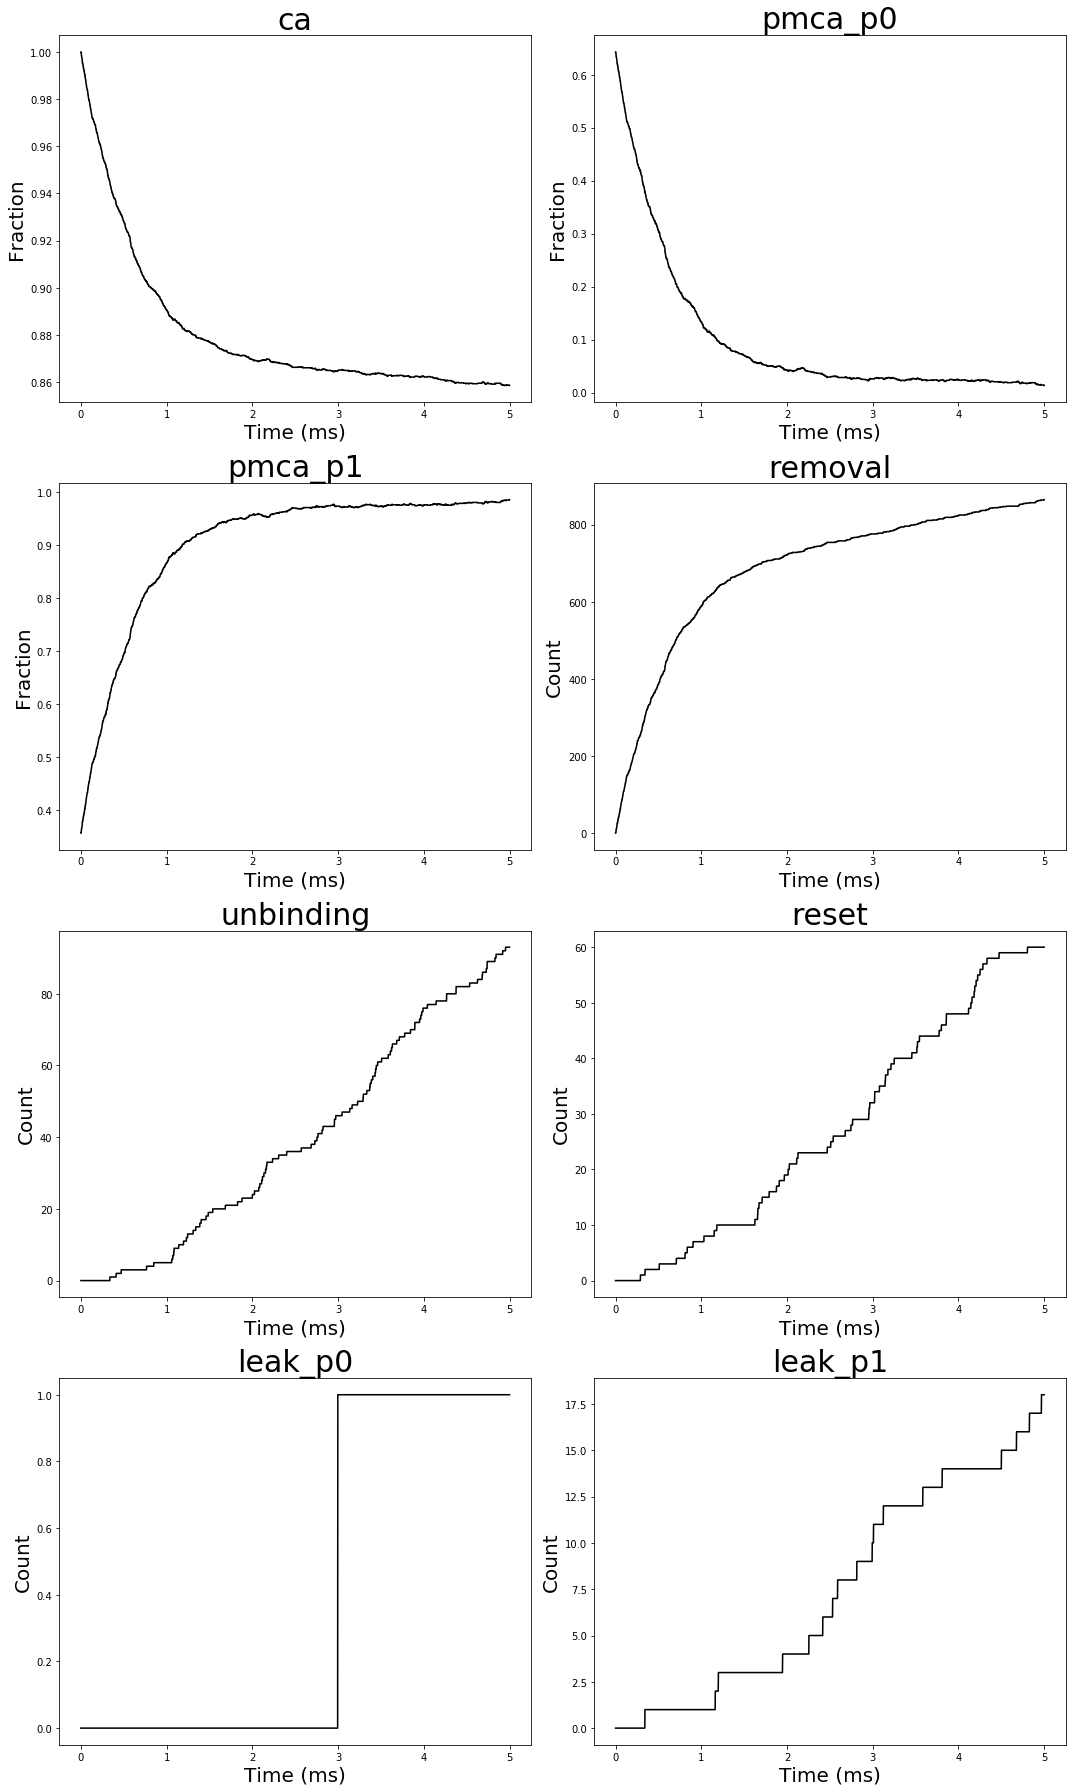

In [26]:
fig, ax = plt.subplots(int(len(mol_files)/2), 2, figsize = (15, 25))

for a, mol in zip(ax.flatten(), range(len(mol_files))):
    for seed in range(SEEDS):
        a.plot(data_norm[mol][:,0,seed]*1000, data_norm[mol][:,1,seed], color='lightgrey')
    mean = np.mean(data_norm[mol], axis=2)
    a.plot(mean[:,0]*1000, mean[:,1], 'k')
    a.set_title(mol_names[mol], size=30)
    a.set_xlabel('Time (ms)', size=20)
    if (mol <= 2):
        a.set_ylabel('Fraction', size=20)
    else:
        a.set_ylabel('Count', size=20)

plt.tight_layout()
plt.show()

### PMCA Volume ODE

In [27]:
from scipy.integrate import solve_ivp
def pmca_odes(t, y):
    '''
     ODEs to describe pmca kinetics according to Bartol et al (2015)
     input:        y:        array of pmca and calcium concentrations (arr, 3 x 1)
     output:       eqtns:       system of odes to describe pmca
     '''
    
    # k_values meaning
    K_1 = 1.5e8    # ca binding and removal (M/s)
    K_2 = 15       # ca unbinding (/s)
    K_3 = 12       # pmca reset (/s)
    K_LEAK = 4.3   # calcium inward leak (/s)
    
    # Unpack input
    ca, p0, p1 = y    # unbound/bound densities and calcium
    
    # System of ODEs
    eqtns = []
    
    # d(ca)/dt
    eqtns.append(-K_1*p0*ca + K_2*p1 + K_LEAK*(p0 + p1))
    
    # d(p0)/dt
    eqtns.append(-K_1*p0*ca + (K_2 + K_3)*p1)
    
    # d(p1)/dt
    eqtns.append(K_1*p0*ca - (K_2 + K_3)*p1)
    
    return eqtns

In [54]:
from scipy.integrate import solve_ivp
'''solve_ivp(fun, t_span, y0)
    - fun:     RHS of the system, fun(t, y)
    - t_span:  integral of integration (t0, tf)
    - y0:      initial state
    
    returns bunch object with:
     - t     (n_points), time points
     - y     (n, n_points), values of the solution at t'''

T_START = 0
T_STOP = 0.005

# Initial concentrations
# convert number to concentration
conc_pmca = n_pmca/(axon_vol * AVAGADRO)
y0 = [conc_ca, 
      conc_pmca * (1 - PMCA_BOUND_FRAC),
      conc_pmca * (PMCA_BOUND_FRAC)
     ]

pmca_sol = solve_ivp(pmca_odes,[T_START, T_STOP], y0, method='LSODA' )

# Normalize
CA_IDX = 0
pmca_sol.y[CA_IDX,:] = pmca_sol.y[CA_IDX,:] / conc_ca
pmca_sol.y[(CA_IDX+1):,:] = pmca_sol.y[(CA_IDX+1):,:] / conc_pmca

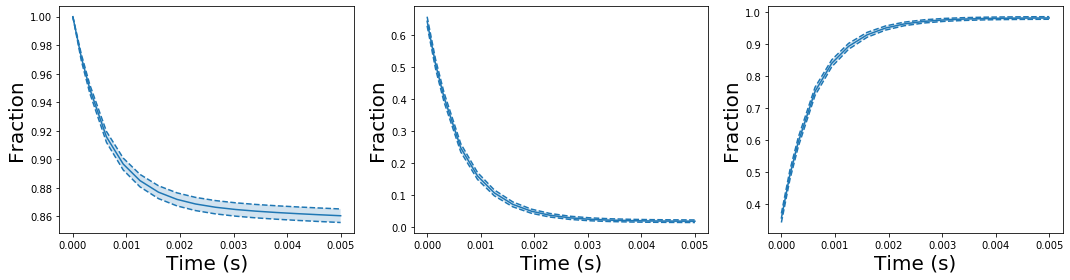

In [58]:
fig, ax = plt.subplots(1, 3, figsize = (15,4))

for a, i in zip(ax.flatten(), range(3)):
    # Mean 
    a.plot(pmca_sol.t, pmca_sol.y[i,:], color='C0')
    
    # Std Dev norm factor
    if (i == CA_IDX):
        N = n_ca_base + N_CA_AP
    else:
        N = n_pmca
        
    # Std dev  
    sd = np.sqrt(np.multiply(pmca_sol.y[i,:], (1 - pmca_sol.y[i,:]))/N)
    a.plot(pmca_sol.t, np.add(pmca_sol.y[i,:], sd), 'C0--')
    a.plot(pmca_sol.t, np.subtract(pmca_sol.y[i,:], sd), 'C0--')
    
    # Cloud 
    a.fill_between(pmca_sol.t, np.add(pmca_sol.y[i,:], sd), np.subtract(pmca_sol.y[i,:], sd), alpha=0.2)
    
    # Mean 
    #a.plot(calb_sol.t, calb_sol.y[i,:])
    #a.set_title(mol_states[i], size=30)
    a.set_xlabel('Time (s)', size=20)
    a.set_ylabel('Fraction', size=20)
    
plt.tight_layout()
plt.show()

### PMCA Volume (MCell and ODE)

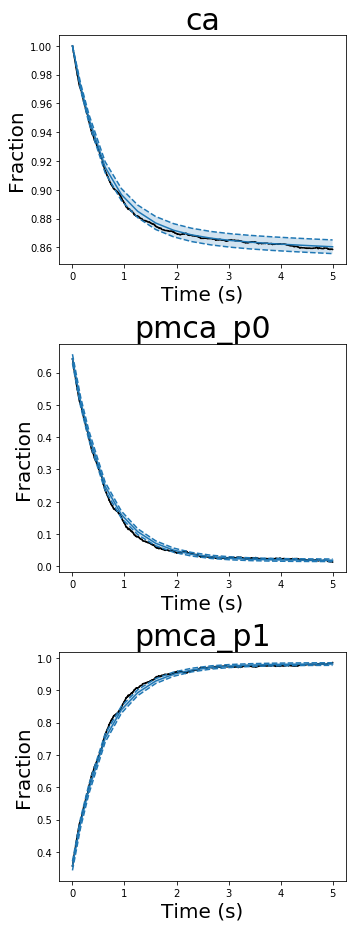

In [77]:
fig, ax = plt.subplots(3, 1, figsize = (5,13))

MS_TO_S = 1000

for a, mol in zip(ax.flatten(), range(3)):
    for seed in range(SEEDS):
        a.plot(data_norm[mol][:,0,seed]*MS_TO_S, data_norm[mol][:,1,seed], color='lightgrey')
    mean = np.mean(data_norm[mol], axis=2)
    a.plot(mean[:,0]*MS_TO_S, mean[:,1], 'k')
    a.set_title(mol_names[mol], size=30)
    a.set_xlabel('Time (ms)', size=20)
    if (mol <= 2):
        a.set_ylabel('Fraction', size=20)
    else:
        a.set_ylabel('Count', size=20)
        
for a, i in zip(ax.flatten(), range(3)):
    # Mean 
    a.plot(pmca_sol.t*MS_TO_S, pmca_sol.y[i,:], color='C0')
    
    # Std Dev norm factor
    if (i == CA_IDX):
        N = n_ca_base + N_CA_AP
    else:
        N = n_pmca
        
    # Std dev  
    sd = np.sqrt(np.multiply(pmca_sol.y[i,:], (1 - pmca_sol.y[i,:]))/N)
    a.plot(pmca_sol.t*MS_TO_S, np.add(pmca_sol.y[i,:], sd), 'C0--')
    a.plot(pmca_sol.t*MS_TO_S, np.subtract(pmca_sol.y[i,:], sd), 'C0--')
    
    # Cloud 
    a.fill_between(pmca_sol.t*MS_TO_S, np.add(pmca_sol.y[i,:], sd), np.subtract(pmca_sol.y[i,:], sd), alpha=0.2)
    
    # Mean 
    #a.plot(calb_sol.t, calb_sol.y[i,:])
    #a.set_title(mol_states[i], size=30)
    a.set_xlabel('Time (s)', size=20)
    a.set_ylabel('Fraction', size=20)

plt.tight_layout()
plt.show()

# Paper Figs

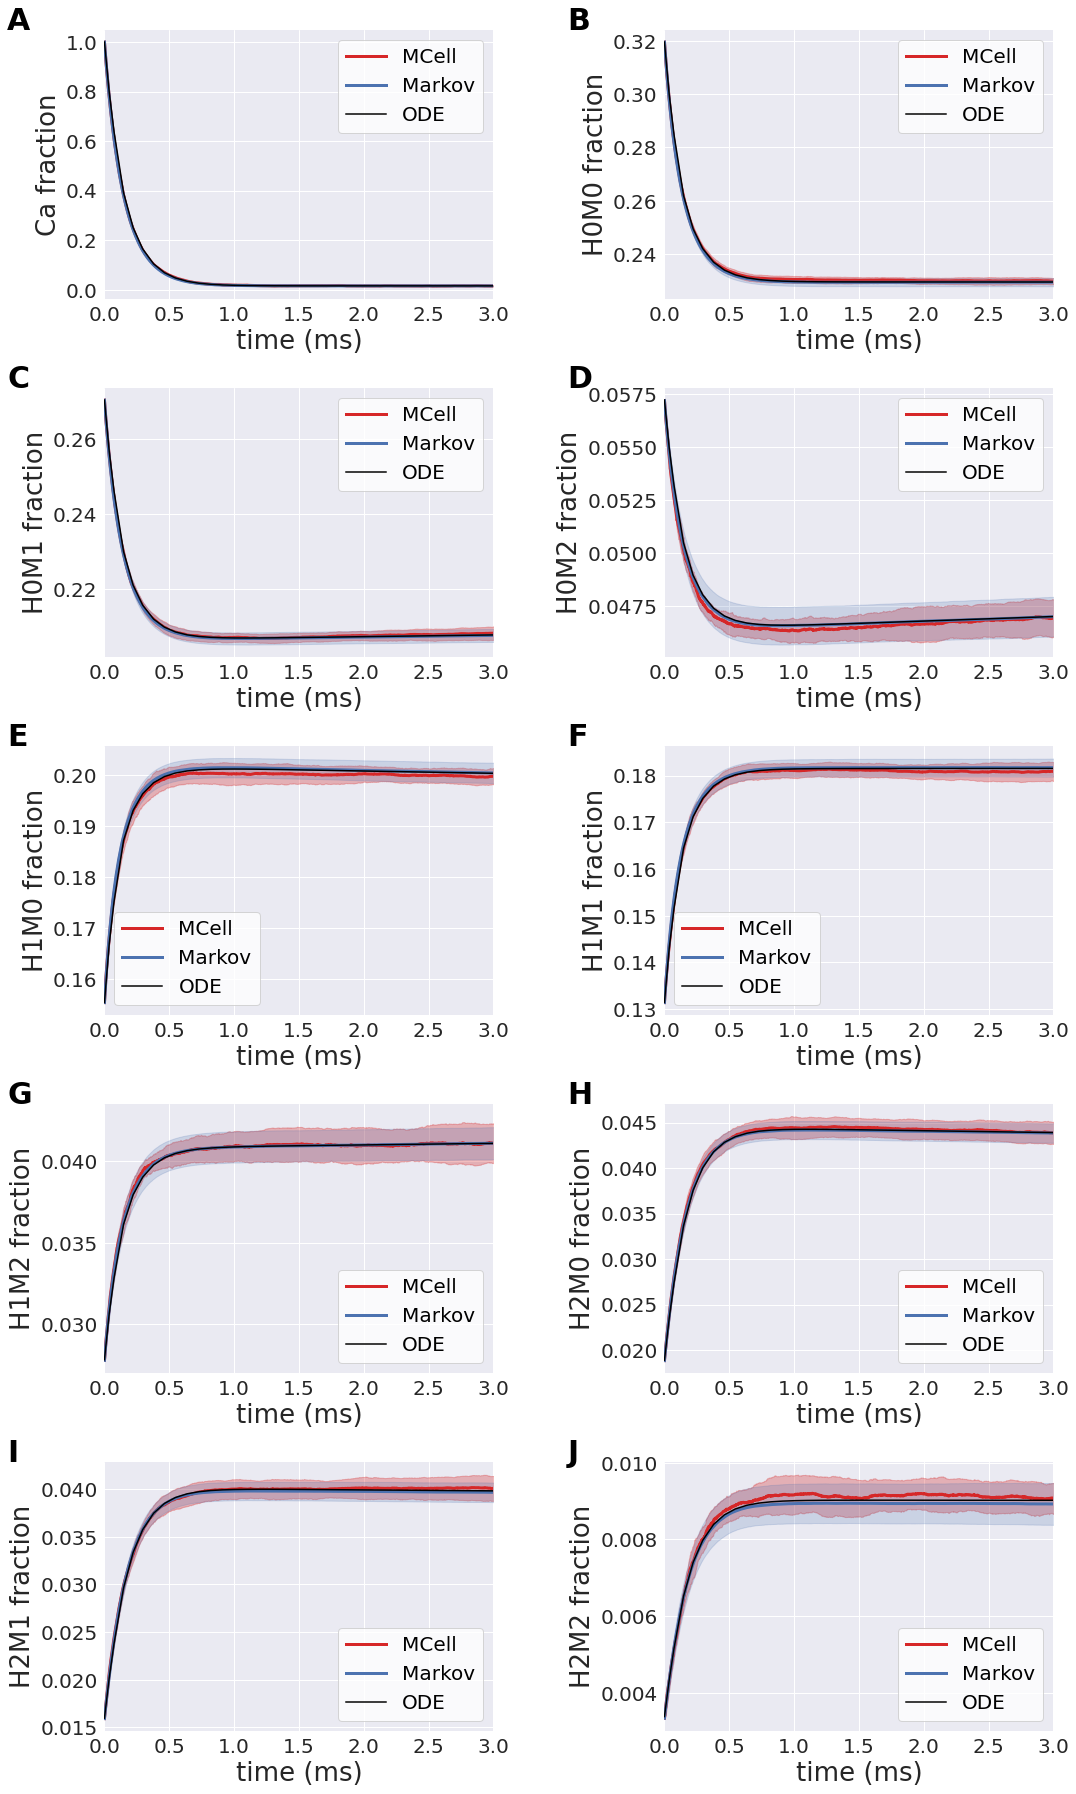

In [31]:
import string
def all_calb():
    with plt.style.context('seaborn'):
        fig, ax = plt.subplots(int(len(mol_files)/2), 2, figsize = (15, 25))
    
    MS_TO_S = 1000
    T_IDX = 0
    VAL_IDX = 1
    lwidth = 3
    
    # order: ['ca', 'calb_h0m0', 'calb_h1m0', 'calb_h2m0', 'calb_h0m1', 'calb_h1m1', 'calb_h2m1', 'calb_h0m2', 'calb_h1m2', 'calb_h2m2']
    names = ["ca", "h0m0", "h0m1", "h0m2","h1m0", "h1m1", "h1m2","h2m0", "h2m1", "h2m2"]
    names_norm = [n + '_norm' for n in names]
    
    '''MCell Trials'''
    for a, mol in zip(ax.flatten(), range(len(mol_files))):
        #for seed in range(SEEDS):
        #    a.plot(data_norm[mol][:,0,seed]*MS_TO_S, data_norm[mol][:,1,seed], color='powderblue')
        # Mean
        mcell_color = 'C3'
        mcell_mean = np.mean(data_norm[mol], axis=2)
        mcell_std = np.std(data_norm[mol], axis=2)
        a.plot(mcell_mean[:,T_IDX]*MS_TO_S, mcell_mean[:,1], color=mcell_color, label='MCell', linewidth=lwidth)
        
        # SEM
        #sem = stats.sem(data_norm[mol], axis=2)
        #a.plot(mean[:,T_IDX]*MS_TO_S, mean[:,VAL_IDX] + sem[:,VAL_IDX], 'C0')
        #a.plot(mean[:,T_IDX]*MS_TO_S, mean[:,VAL_IDX] - sem[:,VAL_IDX], 'C0')
        
        # Cloud plot for std dev
        a.fill_between(mean[:,T_IDX]*MS_TO_S, np.add(mcell_mean[:,1], mcell_std[:,1]), 
                       np.subtract(mcell_mean[:,1], mcell_std[:,1]),alpha=0.3, color=mcell_color) 
        
    '''Markov Solution'''
    for a, n in zip(ax.flatten(), names_norm):
        sns.lineplot(markov_results["timepoints"]*1000, y=n, data=markov_results, 
                    ci="sd", linewidth=lwidth, ax=a, label="Markov")
        
    
    
    '''ODE Solution'''
    # Overlay ODE
    # ode index equivalents
    ODE_IDX = [9, 0, 3, 6, 1, 4, 7, 2, 5, 8]
    
    for a, i in zip(ax.flatten(), ODE_IDX):
        # Std Dev norm factor
        if (i == 1):
            N = N_CA
        else:
            N = N_CALB
            
        # Std dev  
        #sd = np.sqrt(np.multiply(calb_sol.y[i,:], (1 - calb_sol.y[i,:]))/N)
        #a.plot(calb_sol.t*MS_TO_S, np.add(calb_sol.y[i,:], sd), color='darkgrey')
        #a.plot(calb_sol.t*MS_TO_S, np.subtract(calb_sol.y[i,:], sd), color='darkgrey')
        #
        ## Cloud 
        #a.fill_between(calb_sol.t*MS_TO_S, np.add(calb_sol.y[i,:], sd), np.subtract(calb_sol.y[i,:], sd), alpha=0.3,
        #              color='lightgrey')
        
        # Mean 
        a.plot(calb_sol.t*MS_TO_S, calb_sol.y[i,:], 'k', label='ODE')
        a.legend()
        
        
        # Standard error of mean
        #sem = stats.sem(calb_sol.y[i,:])
        #a.plot(calb_sol.t*MS_TO_S, np.add(calb_sol.y[i,:], sem), color='lightgrey', linestyle=':')
        #a.plot(calb_sol.t*MS_TO_S, np.subtract(calb_sol.y[i,:], sem), color='lightgrey', linestyle=':')
        
        
        
    #####################
    # PLOTTING SETTINGS #
    #####################
    names = ["Ca", "H0M0", "H0M1", "H0M2","H1M0", "H1M1", "H1M2","H2M0", "H2M1", "H2M2"]
    for a, i in zip(ax.flatten(), range(len(ODE_IDX))):
        a.text(-0.25, 1, string.ascii_uppercase[i], transform=a.transAxes, size=30, weight='bold')
        a.tick_params(labelsize=20)
        a.set_xlabel('time (ms)', size=26)
        a.set_ylabel('{} fraction'.format(names[i]), size=26)
        a.legend(prop={"size":20})
        a.set_xlim(0, 3)
        
    
    plt.tight_layout(pad=1, w_pad=6)
    plt.savefig('/Users/margotwagner/projects/FrontiersPaper/figs/calb_all.png')
    plt.show()

all_calb()

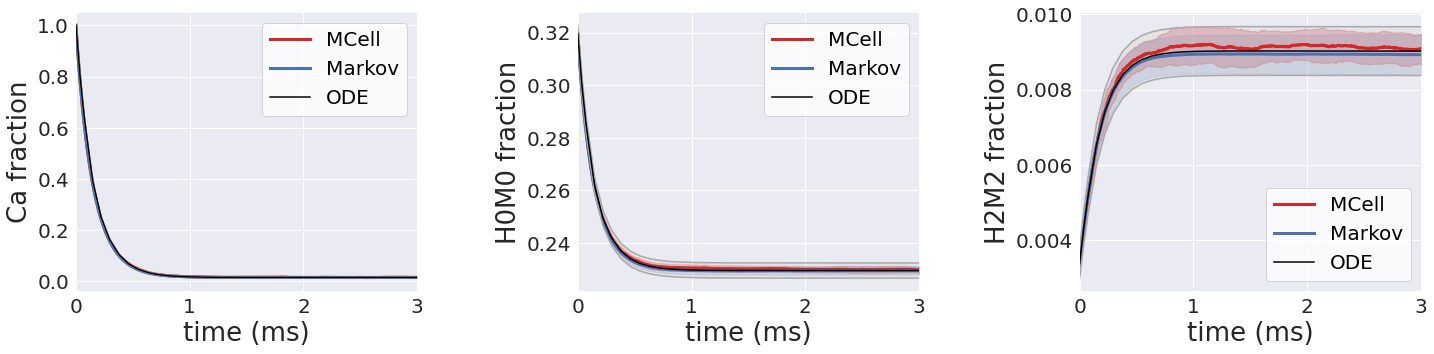

In [35]:
def calb_close():
    with plt.style.context('seaborn'):
        fig, ax = plt.subplots(1, 3, figsize = (20, 5))
    
    MS_TO_S = 1000
    T_IDX = 0
    VAL_IDX = 1
    lwidth = 3
    
    # order: ['ca', 'calb_h0m0', 'calb_h1m0', 'calb_h2m0', 'calb_h0m1', 'calb_h1m1', 'calb_h2m1', 'calb_h0m2', 'calb_h1m2', 'calb_h2m2']
    names = ["Ca", "H0M0", "H2M2"]
    names_norm = [n + '_norm' for n in ["ca", "h0m0", "h2m2"]]
    
    '''MCell Trials'''
    for a, mol in zip(ax.flatten(), [0, 1, 9]):
        #for seed in range(SEEDS):
        #    a.plot(data_norm[mol][:,0,seed]*MS_TO_S, data_norm[mol][:,1,seed], color='powderblue')
        # Mean
        mcell_color = 'C3'
        mcell_mean = np.mean(data_norm[mol], axis=2)
        mcell_std = np.std(data_norm[mol], axis=2)
        a.plot(mcell_mean[:,T_IDX]*MS_TO_S, mcell_mean[:,1], color=mcell_color, label='MCell', linewidth=lwidth)
        
        # Cloud plot for std dev
        a.fill_between(mean[:,T_IDX]*MS_TO_S, np.add(mcell_mean[:,1], mcell_std[:,1]), 
                       np.subtract(mcell_mean[:,1], mcell_std[:,1]),alpha=0.3, color=mcell_color) 
        
    '''Markov Solution'''
    for a, n in zip(ax.flatten(), names_norm):
        sns.lineplot(markov_results["timepoints"]*1000, y=n, data=markov_results, 
                    ci="sd", linewidth=lwidth, ax=a, label="Markov")
        
    
    
    '''ODE Solution'''
    # Overlay ODE
    # ode index equivalents
    ODE_IDX = [9, 0, 8]
    
    for a, i in zip(ax.flatten(), ODE_IDX):
        # Std Dev norm factor
        if (i == 1):
            N = N_CA
        else:
            N = N_CALB
            
        # Std dev  
        sd = np.sqrt(np.multiply(calb_sol.y[i,:], (1 - calb_sol.y[i,:]))/N)
        a.plot(calb_sol.t*MS_TO_S, np.add(calb_sol.y[i,:], sd), color='darkgrey')
        a.plot(calb_sol.t*MS_TO_S, np.subtract(calb_sol.y[i,:], sd), color='darkgrey')
        
        # Cloud 
        a.fill_between(calb_sol.t*MS_TO_S, np.add(calb_sol.y[i,:], sd), np.subtract(calb_sol.y[i,:], sd), alpha=0.3,
                      color='lightgrey')
        
        # Mean 
        a.plot(calb_sol.t*MS_TO_S, calb_sol.y[i,:], 'k', label='ODE')
        a.legend()
        
        
        
    #####################
    # PLOTTING SETTINGS #
    #####################
    for a, i in zip(ax.flatten(), range(len(names))):
        a.tick_params(labelsize=20)
        a.set_xlabel('time (ms)', size=26)
        a.set_ylabel('{} fraction'.format(names[i]), size=26)
        a.legend(prop={"size":20})
        a.set_xlim(0, 3)
        
    
    plt.tight_layout(pad=1, w_pad=6)
    plt.savefig('/Users/margotwagner/projects/FrontiersPaper/figs/calb_close.png')
    plt.show()

calb_close()